# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

## Izhikevich Spiking network model in NEST

For every neuron $i$ in region node $n$ modelled in NEST as a spiking network:

Membrane 

potential:

$ \dot{V}_m = n_2V_m^2 + n_1V_m + n_0140 - U_m/C - g_{AMPA}(V_m-E_{AMPA}) - g_{GABA}(V_m-E_{GABA}) - g_{BASE}V_m + I_e$

where the conductances follow the equations:

$ \dot{g}_{AMPA} = - g_{AMPA} / \tau_{AMPA} + \left[\sum_k \delta(t-t_k) \right]_{Exc}$

$ \dot{g}_{GABA} = - g_{GABA} / \tau_{GABA} + \left[\sum_k \delta(t-t_k) \right]_{Inh}$

$ \dot{g}_{BASE} = - g_{BASE} / \tau_{BASE} + \left[\sum_k \delta(t-t_k) \right]_{BASE}$

and recovery variable:

$ \dot{U}_m = a(bV_m - U_m)$


When $ V_m > V_{th} $ , $ V_m $ is set to $ c $, and $ U_m $ is incremented by $ d $.

# WORKFLOW:

In [1]:
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *
home_path = "/home/docker/packages/tvb-multiscale/examples"
working_path = os.path.join(home_path, "notebooks")
data_path = os.path.join(home_path, "data")
config = Config(output_base=os.path.join(working_path, "outputs_Izhikevich_nest"))
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

Region labels:
['GPe_Left' 'GPi_Left' 'STN_Left' 'Striatum_Left' 'Thal_Left' 'Cortex']


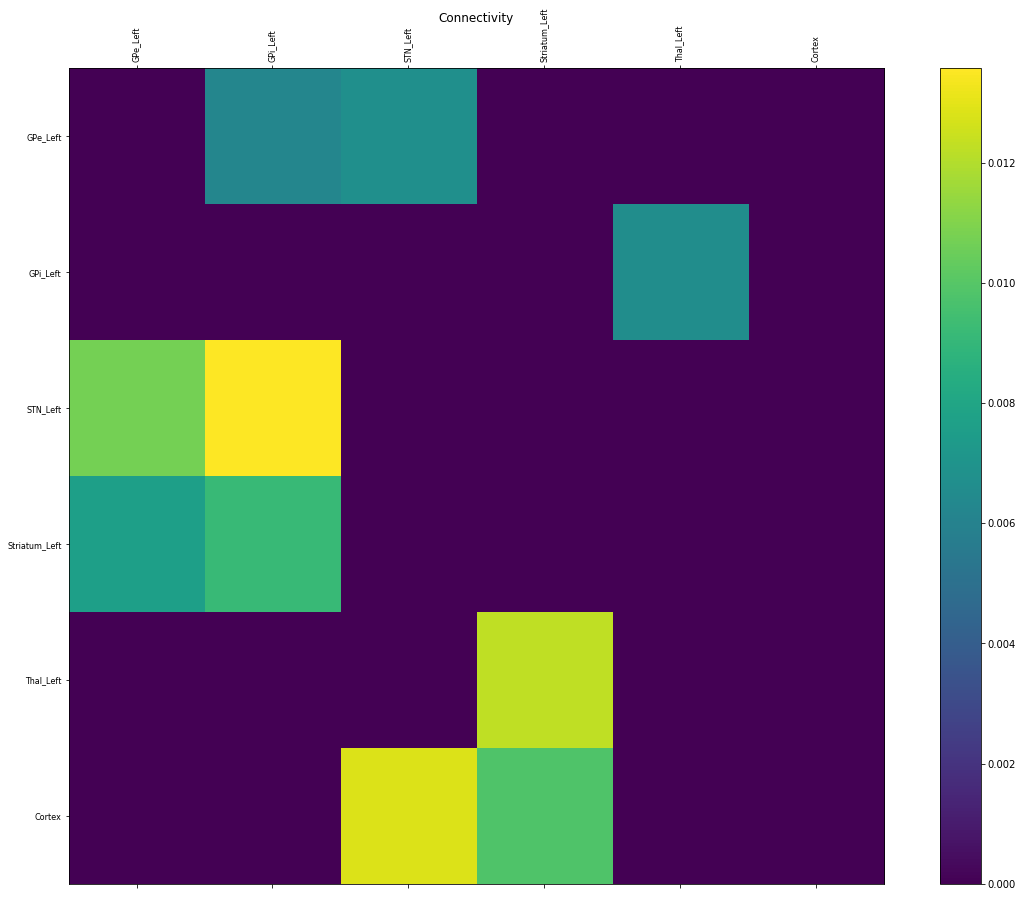

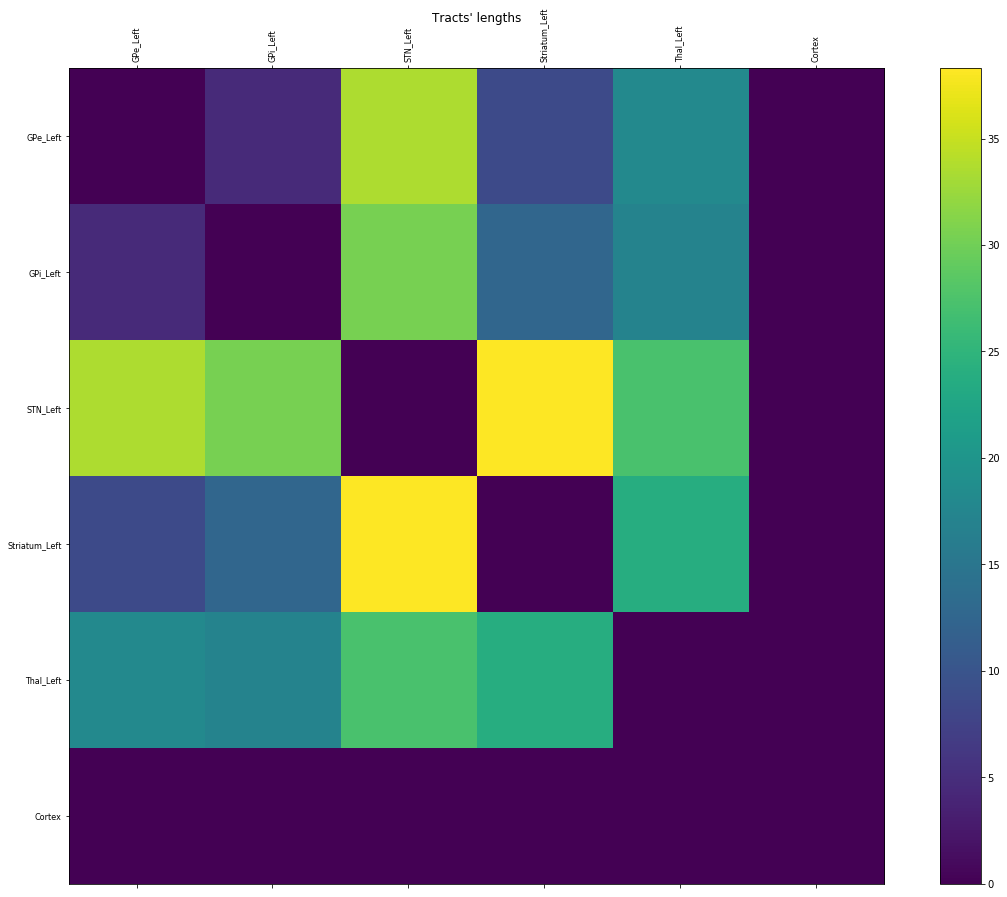

In [2]:
from tvb.simulator.models.reduced_wong_wang_exc_io import ReducedWongWangExcIO

# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the simulator by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------

from tvb.datatypes.connectivity import Connectivity
from tvb.simulator.cosimulator import CoSimulator
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG
    

conn_path = os.path.join(data_path, "basal_ganglia_conn_incl_cortex")

w=np.loadtxt(os.path.join(conn_path, "opti_CON1_lh_weights_incl_cortex.txt"))
c=np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers_incl_cortex.txt"), usecols=range(1,3))
rl= np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers_incl_cortex.txt"), dtype="str", usecols=(0,))
t= np.loadtxt(os.path.join(conn_path, "BGplusAAL_tract_lengths_incl_cortex.txt"))

# Keep only the BG and a single Cortex node:
c = c[:11]
rl = rl[:11]
rl[10] = "Cortex"
w = w[:11][:, :11]
t = t[:11][:, :11]

# Keep only left hemisphere and the Cortex:
inds = np.arange(0,10,2).astype("i").tolist() + [10]
c = c[inds] 
rl = rl[inds]
print("Region labels:\n%s" % rl)
# 0. GPe_Left, 1. GPi_Left, 2. STN_Left, 3. Striatum_Left, 4. Thal_Left, 5. Cortex
w = w[inds][:, inds]
t = t[inds][:, inds]

#load the optimized weights to use for iSN and Cortex connections
import scipy.io as sio
weights=sio.loadmat(os.path.join(conn_path,"OutputSim_Patient01.mat")) # weights start from index 20

# % loadedParams ={
# %     	'D1GPi_probs': probs[0],
# %     	'D1GPi_weights'  : weights[0],
# %     	'D2GPe_probs'   : probs[1],
# %     	'D2GPe_weights'  : weights[1],
# %     	'GPeSTN_probs'   : probs[2],
# %     	'GPeSTN_weights'  : weights[2],
# %     	'STNGPe_probs'   : probs[3],
# %     	'STNGPe_weights'  : weights[3],
# %     	'STNGPi_probs'   : probs[4],
# %     	'STNGPi_weights' : weights[4],
# %     	'GPeGPi_probs'   : probs[5],
# %     	'GPeGPi_weights'  : weights[5],
# %     	'GPeGPe_probs'   : probs[6],
# %     	'GPeGPe_weights'  : weights[6],
# %     	'GPiGPi_probs'   : probs[7],
# %     	'GPiGPi_weights'  : weights[7],
# %     	'GPiThal_probs'   : probs[8],
# %     	'GPiThal_weights'  : weights[8],
# %     	'ThaliSN_probs'   : probs[9],
# %     	'ThaliSN_weights'  : weights[9],
# %     	'ThaldSN_probs'   : probs[10],
# %     	'ThaldSN_weights'  : weights[10],
# %     	'dSNdSN_probs'   : probs[11],
# %     	'dSNdSN_weights'  : weights[11],
# %     	'iSNiSN_probs'   : probs[12],
# %     	'iSNiSN_weights'  : weights[12],
# %     	'CdSN_probs'   : probs[13],
# %     	'CdSN_weights'  : weights[13],
# %     	'CiSN_probs'   : probs[14],
# %     	'CiSN_weights'  : weights[14],
# %     	'CSTN_probs'   : probs[15],
# %     	'CSTN_weights'  : weights[15],
# %     	'V1Inh_probs'    : probs[16],
# %     	'V1Inh_weights'  : weights[16],
# %     	'InhV1_probs'    : probs[17],
# %     	'InhV1_weights'  : weights[17],
# %     	'InhInh_probs'   : probs[18],
# %     	'InhInh_weights'  : weights[18]}

# dSN = dSN, iSN = iSN from now on

wGPeGPe = weights["X"][0, 6+19]   # "GPe" -> "GPe" 
wGPiGPi = weights["X"][0, 7+19]   # "GPe" -> "GPe" 
wdSNdSN = weights["X"][0, 11+19]   # "IdSN" -> "IdSN" 
wiSNiSN = weights["X"][0, 12+19]   # "IiSN" -> "IiSN" 
wThiSN = weights["X"][0, 9+19]    # "Eth" -> "IiSN" 
# wThdSNtoThiSN = wThiSN / w[4, 3]
w[5, 2] = weights["X"][0, 15+19]  # "CxE" -> "Estn"
w[5, 3] = weights["X"][0, 13+19]  # "CxE" -> "IdSN" 
wCrtxiSN = weights["X"][0, 14+19] # "CxE" -> "IiSN" 
# wCrtxdSNtoCrtxiSN = weights["X"][0, 14+19] / w[5, 3]
wCtxEtoI = weights["X"][0, 16+19] # "CxE" -> "CxI"
wCtxItoE = weights["X"][0, 17+19] # "CxI" -> "CxE"
wCtxItoI = weights["X"][0, 18+19] # "CxI" -> "CxI"

# Finally form the TVB Connectivity
connectivity=Connectivity(region_labels=rl, weights=w, centres=c, tract_lengths=t)

# Normalize connectivity weights
# connectivity.weights = connectivity.scaled_weights(mode="region")
# connectivity.weights /= np.percentile(connectivity.weights, 99)
# connectivity.weights[connectivity.weights > 1.0] = 1.0
connectivity.speed = np.array([4.0])
connectivity.configure()

#white_matter_coupling = coupling.Linear(a=0.014)
# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = CoSimulator()
#simulator.use_numba = False
model_params = {}
simulator.model = ReducedWongWangExcIO(**model_params)

simulator.connectivity = connectivity

simulator.integrator = HeunStochastic()
simulator.integrator.dt = 0.1
simulator.integrator.noise.nsig = np.array([0.001])

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )

plotter.plot_tvb_connectivity(simulator.connectivity);

## 2. Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [3]:
from tvb_multiscale.tvb_nest.nest_models.builders.models.basal_ganglia_izhikevich import BasalGangliaIzhikevichBuilder

# Select the regions for the fine scale modeling with NEST spiking networks
number_of_regions = simulator.connectivity.region_labels.shape[0]
#including cortex node:
nest_nodes_ids = [0, 1, 2, 3, 4, 5]  # the indices of fine scale regions modeled with NEST

# Build a NEST network model with the corresponding builder
nest_model_builder = BasalGangliaIzhikevichBuilder(simulator, nest_nodes_ids, config=config, 
#                                                    dt=float(simulator.integrator.dt),
#                                                    weights=np.array(simulator.connectivity.weights), 
#                                                    delays=np.array(simulator.connectivity.delays), 
#                                                    region_labels=np.array(simulator.connectivity.region_labels), 
#                                                    model=simulator.model, 
#                                                    coupling_a=float(simulator.coupling.a[0].item()),
#                                                    G=float(simulator.model.G[0].item())
                                                  )



# Using all default parameters for this example


# or...

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
from copy import deepcopy

population_neuron_model = "izhikevich_hamker"

nest_model_builder.population_order = 200 # reduce for speed

# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

nest_model_builder.params_common = \
    {"E_rev_AMPA": 0.0, "E_rev_GABA_A": -90.0, "V_th": 30.0, "c": -65.0,
     "C_m": 1.0, "I_e": 0.0,
     "tau_rise": 1.0, "tau_rise_AMPA": 10.0, "tau_rise_GABA_A": 10.0,
     "n0": 140.0, "n1": 5.0, "n2": 0.04}

nest_model_builder._paramsI = deepcopy(nest_model_builder.params_common)
nest_model_builder._paramsI.update({"a": 0.005, "b": 0.585, "d": 4.0})
nest_model_builder._paramsE = deepcopy(nest_model_builder.params_common)
nest_model_builder.paramsStr = deepcopy(nest_model_builder.params_common)
nest_model_builder.paramsStr.update({"V_th": 40.0, "C_m": 50.0, 
                                     "n0": 61.65, "n1": 2.59, "n2": 0.02, 
                                     "a": 0.05, "b": -20.0, "c": -55.0, "d": 377.0})

nest_model_builder.Igpe_nodes_ids = [0]
nest_model_builder.Igpi_nodes_ids = [1]
nest_model_builder.Estn_nodes_ids = [2]
nest_model_builder.Eth_nodes_ids = [4]
nest_model_builder.Istr_nodes_ids = [3]
#including cortex node:
nest_model_builder.Crtx_nodes_ids = [5]

I_nodes_ids = nest_model_builder.Igpe_nodes_ids + nest_model_builder.Igpi_nodes_ids + nest_model_builder.Crtx_nodes_ids
E_nodes_ids = nest_model_builder.Estn_nodes_ids + nest_model_builder.Eth_nodes_ids + nest_model_builder.Crtx_nodes_ids

# #including cortex node: we do not need any other external stimulation
# nest_model_builder.Estn_stim = {"rate": 500.0, "weight": 0.009}
# nest_model_builder.Igpe_stim = {"rate": 100.0, "weight": 0.015}
# nest_model_builder.Igpi_stim = {"rate": 700.0, "weight": 0.02}


def paramsE_fun(node_id):
    paramsE = deepcopy(nest_model_builder._paramsE)
    if node_id in nest_model_builder.Estn_nodes_ids:
        paramsE.update({"a": 0.005, "b": 0.265, "d": 2.0, "I_e": 3.0})  # dictionary of params for Estn
    elif node_id in nest_model_builder.Eth_nodes_ids:
        paramsE.update({"a": 0.02, "b": 0.25, "d": 0.05, "I_e": 3.5}) # dictionary of params for Eth
    elif node_id in nest_model_builder.Crtx_nodes_ids:
        paramsE.update({"a": 0.02, "b": 0.2, "d": 6.0,"c": -72.0, "I_e": 50.0}) # dictionary of params for CortexExcitatory
    return paramsE
    
def paramsI_fun(node_id):
    # For the moment they are identical, unless you differentiate the noise parameters
    paramsI = deepcopy(nest_model_builder._paramsI)
    if node_id in nest_model_builder.Igpe_nodes_ids:
        paramsI.update({"I_e": 12.0})
    elif node_id in nest_model_builder.Igpi_nodes_ids:
        paramsI.update({"I_e": 30.0})
    elif node_id in nest_model_builder.Crtx_nodes_ids:
        paramsI.update({"c": -72.0,"a": 0.02, "b": 0.2, "d": 6.0, "I_e": 0.0})
    return paramsI
    
# Populations' configurations
# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property
nest_model_builder.populations = [
    {"label": "E", "model": population_neuron_model,  
     "params":  paramsE_fun, 
     "nodes": E_nodes_ids,  # Estn in [2], Eth in [4], Cortex in [5]
     "scale": lambda node_id: 3.0 if node_id in nest_model_builder.Crtx_nodes_ids else 1.0},
    {"label": "I", "model": population_neuron_model,  
     "params": paramsI_fun, 
     "nodes": I_nodes_ids,  # Igpe in [0], Igpi in [1], Cortex in [5]
     "scale": lambda node_id: 0.75 if node_id in nest_model_builder.Crtx_nodes_ids else 1.0},
    {"label": "IdSN", "model": population_neuron_model,   
     "params": nest_model_builder.paramsStr, 
     "nodes": nest_model_builder.Istr_nodes_ids,  # IdSN in [3]
     "scale": 1.0},
    {"label": "IiSN", "model": population_neuron_model,   # IiSN in [3]
     "params": nest_model_builder.paramsStr, 
     "nodes": nest_model_builder.Istr_nodes_ids,  # None means "all"
     "scale": 1.0}
]

# Within region-node connections
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

synapse_model = "static_synapse"
conn_spec = {"allow_autapses": True, "allow_multapses": True, 'rule': "all_to_all",
             "indegree": None, "outdegree": None, "N": None, "p": 0.1}

within_node_delay = 1.0

class WeightFun(object):

    def __init__(self, wGPeGPe, wGPiGPi, wCtxItoI):
        self.wGPeGPe = -np.abs(wGPeGPe)
        self.wGPiGPi = -np.abs(wGPiGPi)
        self.wCtxItoI = -np.abs(wCtxItoI)
        
    def __call__(self, node):
        if node == 0:
            return self.wGPeGPe  # GPe -> GPe
        elif node == 1:
            return self.wGPiGPi  # GPi -> GPi
        elif node == 5:
            return self.wCtxItoI  # CxI -> CxI
        

# for each connection, we have a different probability
nest_model_builder.populations_connections = [
     #        source   ->   target
    {"source": "I", "target": "I",  # I -> I This is a self-connection for populations "Igpe", "Igpi" and CxI
     "model": synapse_model, "conn_spec": conn_spec,#.update({"p": 0.2}),
     "weight": WeightFun(wGPeGPe, wGPiGPi, wCtxItoI), "delay": within_node_delay,
     "receptor_type": 0, "nodes": I_nodes_ids},  # None means apply to all
    {"source": "IdSN", "target": "IdSN",  # IdSN -> IdSN This is a self-connection for population "IdSN"
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": -wdSNdSN, "delay": within_node_delay,
     "receptor_type": 0, "nodes": nest_model_builder.Istr_nodes_ids},
    {"source": "IiSN", "target": "IiSN",  # IiSN -> IiSN This is a self-connection for population "IiSN"
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": -wiSNiSN, "delay": within_node_delay,
     "receptor_type": 0, "nodes": nest_model_builder.Istr_nodes_ids},
    {"source": "E", "target": "I",          # "CxE" -> "CxI" #
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": wCtxEtoI, "delay": within_node_delay,  
     "receptor_type": 0, "nodes": nest_model_builder.Crtx_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",          # "CxI" -> "CxE" 
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": -wCtxItoE, "delay": within_node_delay,  
     "receptor_type": 0, "nodes": nest_model_builder.Crtx_nodes_ids}  # None means apply to all   
    ]



# Among/Between region-node connections
# Given that only the AMPA population of one region-node couples to
# all populations of another region-node,
# we need only one connection type
        
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# depends on regions, set a handle to a function with
# arguments (source_region_index=None, target_region_index=None)

from tvb_multiscale.core.spiking_models.builders.templates import scale_tvb_weight, tvb_delay

# NOTE!!! TAKE CARE OF DEFAULT simulator.coupling.a!
nest_model_builder.global_coupling_scaling = 1.0 # nest_model_builder.coupling_a 
# if we use Reduced Wong Wang model, we also need to multiply with the global coupling constant G:
# nest_model_builder.global_coupling_scaling *= nest_model_builder.G
        
class TVBWeightFun(object):
    tvb_weights = np.array([])
    global_coupling_scaling = 1.0
    sign = 1

    def __init__(self, tvb_weights, global_coupling_scaling=1.0, sign=1):
        self.tvb_weights = tvb_weights
        self.global_coupling_scaling = global_coupling_scaling
        self.sign = sign

    def __call__(self, source_node, target_node):
        return scale_tvb_weight(source_node, target_node, self.tvb_weights,
                                scale=self.sign*self.global_coupling_scaling)
    
tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(nest_model_builder.tvb_dt, tvb_delay(source_node, target_node, nest_model_builder.tvb_delays))

# Total excitatory spikes of one region node will be distributed to
nest_model_builder.nodes_connections = [
    #        source    ->     target
    {"source": "IdSN", "target": "I",             # "IdSN" -> "Igpi"
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(nest_model_builder.tvb_weights, nest_model_builder.global_coupling_scaling, -1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Istr_nodes_ids, 
     "target_nodes": nest_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "IiSN", "target": "I",            # "IiSN" -> "Igpe"
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(nest_model_builder.tvb_weights, nest_model_builder.global_coupling_scaling, -1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Istr_nodes_ids, 
     "target_nodes": nest_model_builder.Igpe_nodes_ids},  # None means apply to all
    {"source": "I", "target": "I",             # "Igpe" -> "Igpi"
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(nest_model_builder.tvb_weights, nest_model_builder.global_coupling_scaling, -1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpe_nodes_ids, 
     "target_nodes": nest_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",              # "Igpi" -> "Eth"
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(nest_model_builder.tvb_weights, nest_model_builder.global_coupling_scaling, -1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpi_nodes_ids, 
     "target_nodes": nest_model_builder.Eth_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",             # "Igpe" -> "Estn"
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(nest_model_builder.tvb_weights, nest_model_builder.global_coupling_scaling, -1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpe_nodes_ids, 
     "target_nodes": nest_model_builder.Estn_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IdSN",   # "Eth" -> ["IdSN"] 
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(nest_model_builder.tvb_weights, nest_model_builder.global_coupling_scaling, 1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Eth_nodes_ids, 
     "target_nodes": nest_model_builder.Istr_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IiSN",   # "Eth" -> ["IiSN"] 
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": wThiSN,
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Eth_nodes_ids, 
     "target_nodes": nest_model_builder.Istr_nodes_ids},  # No
    {"source": "E", "target": "I",          # "Estn" -> ["Igpe", "Igpi"]
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(nest_model_builder.tvb_weights, nest_model_builder.global_coupling_scaling, 1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Estn_nodes_ids, 
     "target_nodes": nest_model_builder.Igpe_nodes_ids + nest_model_builder.Igpi_nodes_ids},
#     {"source": "E", "target": "E",          # "CxE" -> "Eth"
#      "model": synapse_model, "conn_spec": conn_spec,
#      "weight": TVBWeightFun(nest_model_builder.tvb_weights, nest_model_builder.global_coupling_scaling, 1),
#      "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
#      "receptor_type": 0, 
#      "source_nodes": nest_model_builder.Crtx_nodes_ids, 
#      "target_nodes": nest_model_builder.Eth_nodes_ids},  # None means apply to all
    {"source": "E", "target": "E",          # "CxE" -> "Estn"
     "model": synapse_model, "conn_spec": conn_spec, 
     "weight": TVBWeightFun(nest_model_builder.tvb_weights, nest_model_builder.global_coupling_scaling, 1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Crtx_nodes_ids, 
     "target_nodes": nest_model_builder.Estn_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IdSN",          # "CxE" -> "IdSN" 
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(nest_model_builder.tvb_weights, nest_model_builder.global_coupling_scaling, 1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Crtx_nodes_ids, 
     "target_nodes": nest_model_builder.Istr_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IiSN",          # "CxE" -> "IiSN" 
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": wCrtxiSN, # TVBWeightFun(nest_model_builder.tvb_weights, 
                            # wCrtxdSNtoCrtxiSN * nest_model_builder.global_coupling_scaling, 1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Crtx_nodes_ids,
     "target_nodes": nest_model_builder.Istr_nodes_ids}  # None means apply to all
     ]

# Creating  devices to be able to observe NEST activity:

nest_model_builder.output_devices = []

#          label <- target population
for pop in nest_model_builder.populations:
    connections = OrderedDict({})
    connections[pop["label"] + "_spikes"] = pop["label"]
    nest_model_builder.output_devices.append(
        {"model": "spike_recorder", "params": {"record_to": "ascii"},
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to "all"

# Labels have to be different

connections = OrderedDict({})
#               label    <- target population
params = {"interval": 1.0, "record_to": "ascii",
          'record_from': ["V_m", "U_m", "I_syn", "I_syn_ex", "I_syn_in", "g_AMPA", "g_GABA_A", "g_L"]}
for pop in nest_model_builder.populations:
    connections = OrderedDict({})
    connections[pop["label"]] = pop["label"]
    nest_model_builder.output_devices.append(
        {"model": "multimeter", "params": params,
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to all
    

#Create a spike stimulus input device
nest_model_builder.input_devices = [
#     {"model": "poisson_generator",
#      "params": {"rate": nest_model_builder.Estn_stim["rate"], "origin": 0.0, "start": 0.1},
#      "connections": {"BaselineEstn": ["E"]},  # "Estn"
#      "nodes": nest_model_builder.Estn_nodes_ids,  # "Estn"
#      "weights": nest_model_builder.Estn_stim["weight"], "delays": 0.0, "receptor_type": 1},
#     {"model": "poisson_generator",
#      "params": {"rate": nest_model_builder.Igpe_stim["rate"], "origin": 0.0, "start": 0.1},
#      "connections": {"BaselineIgpe": ["I"]},  # "Igpe"
#      "nodes": nest_model_builder.Igpe_nodes_ids,  # "Igpe"
#      "weights": nest_model_builder.Igpe_stim["weight"], "delays": 0.0, "receptor_type": 1},
#     {"model": "poisson_generator",
#      "params": {"rate": nest_model_builder.Igpi_stim["rate"], "origin": 0.0, "start": 0.1},
#      "connections": {"BaselineIgpi": ["I"]},  # "Igpi"
#      "nodes": nest_model_builder.Igpi_nodes_ids,  ## "Igpi"
#      "weights": nest_model_builder.Igpi_stim["weight"], "delays": 0.0, "receptor_type": 1},
#     {"model": "ac_generator",
#      "params": {"frequency": 30.0, "phase": 0.0, "amplitude": 1.0, "offset": 0.0,
#                 "start": 1.0},  # "stop": 100.0  "origin": 0.0, 
#      "connections": {"DBS_Estn": ["E"]}, # "Estn"
#      "nodes": nest_model_builder.Estn_nodes_ids,      # "Estn"
#      "weights": 1.0, "delays": 0.0}
       ]  #

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------


nest_network = nest_model_builder.build_spiking_network()


2020-11-26 15:28:10,300 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Loading a NEST instance...
2020-11-26 15:28:10,300 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Loading a NEST instance...
2020-11-26 15:28:10,304 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2020-11-26 15:28:10,304 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2020-11-26 15:28:10,311 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2020-11-26 15:28:10,311 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2020-11-26 15:28:10,317 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2020-11-26 15:28:10,317 - INFO - tvb_multiscale.t

2020-11-26 15:28:10,578 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Trying to install module izhikevich_hamkermodule...
2020-11-26 15:28:10,578 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Trying to install module izhikevich_hamkermodule...
2020-11-26 15:28:10,616 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - DONE installing module izhikevich_hamkermodule!
2020-11-26 15:28:10,616 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - DONE installing module izhikevich_hamkermodule!
2020-11-26 15:28:11,172 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for E_spikes created!
2020-11-26 15:28:11,172 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for E_spikes created!
2020-11-26 15:28:12,008 - INFO - tvb_multiscale.core.spiking_models.devices - <class '

In [4]:
print(nest_network.print_str(connectivity=False))



----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
NESTNetwork:

----------------------------------------------------------------------------------------------------

SpikingBrain - Regions: ['GPe_Left', 'GPi_Left', 'STN_Left', 'Striatum_Left', 'Thal_Left', 'Cortex']
Regions' nodes:


----------------------------------------------------------------------------------------------------
NESTRegionNode - Label: GPe_Left
Populations ['I']:

----------------------------------------------------------------------------------------------------

NESTPopulation - Label: I 
model: izhikevich_hamker
200 neurons: 1...200
parameters: {'a': array([0.005]), 'archiver_length': 0, 'b': array([0.585]), 'beta_Ca': array([0.001]), 'C_m': array([1.]), 'Ca': 

## 3. Build the TVB-NEST interface

In [5]:
from tvb_multiscale.tvb_nest.interfaces.builders.models.red_ww_basal_ganglia_izhikevich import RedWWexcIOBuilder

# Build a TVB-NEST interface with all the appropriate connections between the
# TVB and NEST modelled regions
tvb_nest_builder = \
    RedWWexcIOBuilder(simulator, nest_network, nest_nodes_ids, 
                      exclusive_nodes=True) # , populations_sizes=populations_sizes

tvb_to_nest_mode = None  # "rate" # with none we get the NEST-only part here for the whole model
nest_to_tvb = False

tvb_nest_model = tvb_nest_builder.build_interface(tvb_to_nest_mode=tvb_to_nest_mode, nest_to_tvb=nest_to_tvb)

2020-11-26 15:28:21,936 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2020-11-26 15:28:21,936 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2020-11-26 15:28:21,941 - INFO - tvb_multiscale.tvb_nest.interfaces.models - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2020-11-26 15:28:21,941 - INFO - tvb_multiscale.tvb_nest.interfaces.models - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!


In [6]:
print(tvb_nest_model.print_str(detailed_output=True, connectivity=False))


----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
RedWWexcIO TVB-NEST Interface




## 4. Configure simulator, simulate, gather results

In [7]:
# Configure the simulator with the TVB-NEST interface...
simulator.configure(tvb_spikeNet_interface=tvb_nest_model)
# ...and simulate!
t = time.time()
simulation_length=110.0
transient = 10.0 # simulation_length/11
results = simulator.run(simulation_length=simulation_length)
# Integrate NEST one more NEST time step so that multimeters get the last time point
# unless you plan to continue simulation later
simulator.run_spiking_simulator(simulator.tvb_spikeNet_interface.nest_instance.GetKernelStatus("resolution"))
print("\nSimulated in %f secs!" % (time.time() - t))


Simulated in 8.536161 secs!


In [8]:
# Clean-up NEST simulation
simulator.tvb_spikeNet_interface.nest_instance.Cleanup()

## 5. Plot results and write them to HDF5 files

In [9]:
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
# from examples.plot_write_results import plot_write_results
# populations = []
# populations_sizes = []
# for pop in nest_model_builder.populations:
#     populations.append(pop["label"])
#     populations_sizes.append(int(np.round(pop["scale"] * nest_model_builder.population_order)))
# plot_write_results(results, simulator, populations=populations, populations_sizes=populations_sizes, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [10]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
        data=results[0][1], time=results[0][0],
        connectivity=simulator.connectivity,
        labels_ordering=["Time", "State Variable", "Region", "Neurons"],
        labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                           "Region": simulator.connectivity.region_labels.tolist()},
        sample_period=simulator.integrator.dt)
source_ts.configure()

t = source_ts.time
    
# # Write to file
# if writer:
#     writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
#                                                                     connectivity=source_ts.connectivity),
#                            os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
source_ts

del source_ts

In [11]:
# # Plot TVB time series
# source_ts.plot_timeseries(plotter_config=plotter.config, 
#                           hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
#                           per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
#                           figsize=FIGSIZE);

In [12]:
# # TVB time series raster plot:
# if source_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts.plot_raster(plotter_config=plotter.config, 
#                           per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS,
#                           figsize=FIGSIZE);

In [13]:
# # Focus on the nodes modelled in NEST: 
# n_spiking_nodes = len(simulator.tvb_spikeNet_interface.spiking_nodes_ids)
# source_ts_nest = source_ts[:, :, simulator.tvb_spikeNet_interface.spiking_nodes_ids]
# source_ts_nest.plot_timeseries(plotter_config=plotter.config, 
#                                hue="Region" if source_ts_nest.shape[2] > MAX_REGIONS_IN_ROWS else None, 
#                                per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS, 
#                                figsize=FIGSIZE, figname="Spiking nodes TVB Time Series");

In [14]:
# # Focus on the nodes modelled in NEST: raster plot
# if source_ts_nest.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts_nest.plot_raster(plotter_config=plotter.config, 
#                                per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS,
#                                figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

### Interactive time series plot

In [15]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)

### Spiking Network plots

In [16]:
from tvb_multiscale.tvb_elephant.spiking_network_analyser import SpikingNetworkAnalyser
# Create a SpikingNetworkAnalyzer:
spikeNet_analyzer = \
    SpikingNetworkAnalyser(spikeNet=nest_network,
                           start_time=t[0], end_time=t[-1], 
                           period=simulator.monitors[0].period, transient=transient,
                           time_series_output_type="TVB", return_data=True, 
                           force_homogeneous_results=True, connectivity=simulator.connectivity)

### Plot spikes' raster and mean spike rates and correlations

In [17]:
# Spikes rates and correlations per Population and Region
spikes_res = \
    spikeNet_analyzer.\
        compute_spikeNet_spikes_rates_and_correlations(
            populations_devices=None, regions=None,
            rates_methods=[], rates_kwargs=[{}],rate_results_names=[],
            corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
            data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
            return_devices=False
        );

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:990: UserWarning:Correcting 400 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:990: UserWarning:Correcting 150 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:990: UserWarning:Correcting 200 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:495: UserWarning:Binning discarded 10950 last spike(s) in the input spiketrain.
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/spike_train_correlation.py:510: UserWarning:Detected empty spike trains (ro

<xarray.DataArray "Mean Populations' Spikes' Rates" (Population: 4, Region: 6)>
array([[0.04004004,        nan,        nan, 0.08008008,        nan,
        0.        ],
       [0.08008008, 0.07007007, 0.05005005,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan, 0.04004004,
               nan],
       [       nan,        nan,        nan,        nan, 0.04004004,
               nan]])
Coordinates:
  * Region      (Region) object 'Cortex' 'GPe_Left' ... 'Thal_Left'
  * Population  (Population) object 'E_spikes' 'I_spikes' ... 'IiSN_spikes'
<xarray.DataArray "Populations' Correlation Coefficient" (Population_i: 4, Population_j: 4, Region_i: 6, Region_j: 6)>
array([[[[nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan]],

        [[nan, nan, nan, nan, nan, nan]

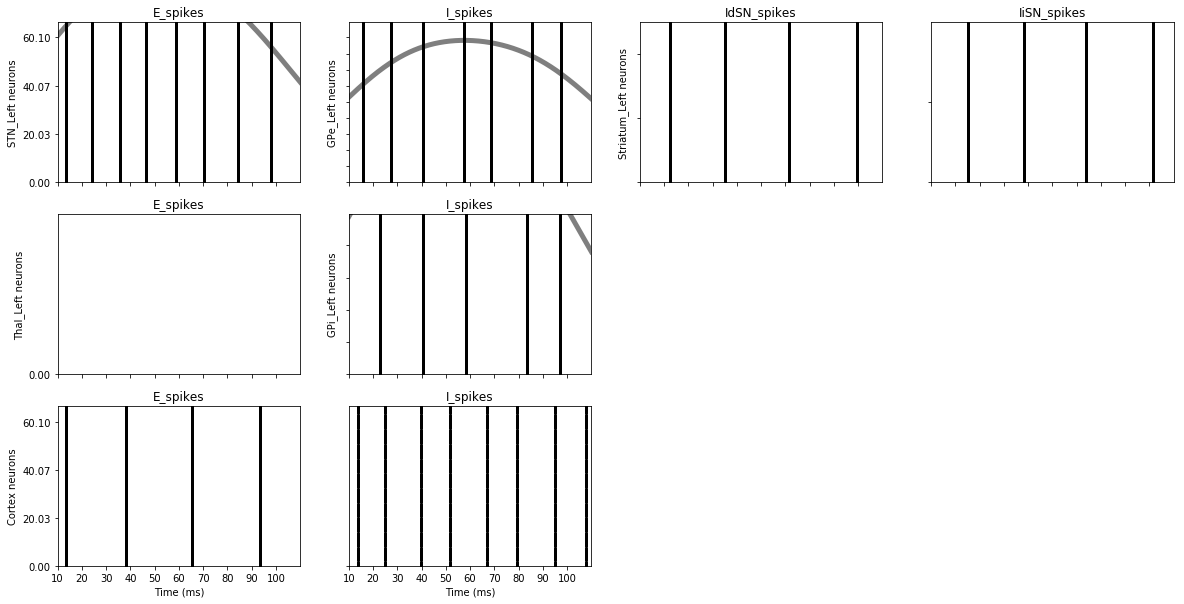

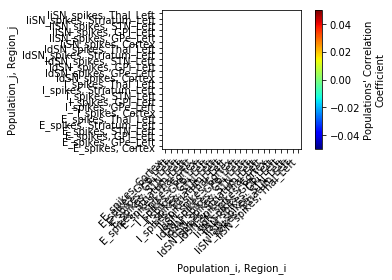

In [18]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.plot_spike_events(spikes_res["spikes"], rates=spikes_res["mean_rate_time_series"], figsize=FIGSIZE)
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)

In [19]:
if spikes_res and writer:
    writer.write_object(spikes_res["spikes"].to_dict(), 
                        path=os.path.join(config.out.FOLDER_RES,  "Spikes") + ".h5");
    writer.write_object(spikes_res["mean_rate"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["mean_rate"].name) + ".h5");
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                              spikes_res["mean_rate_time_series"]._data,
                               connectivity=spikes_res["mean_rate_time_series"].connectivity),
                           os.path.join(config.out.FOLDER_RES,
                                        spikes_res["mean_rate_time_series"].title) + ".h5",
                           recursive=False);
    writer.write_object(spikes_res["spikes_correlation_coefficient"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["spikes_correlation_coefficient"].name) + ".h5");

2020-11-26 15:28:39,242 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/notebooks/outputs_Izhikevich_nest/res/Spikes.h5
2020-11-26 15:28:39,242 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/notebooks/outputs_Izhikevich_nest/res/Spikes.h5
2020-11-26 15:28:39,281 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2020-11-26 15:28:39,281 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2020-11-26 15:28:39,293 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2020-11-26 15:28:39,293 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2020-11-26 15:28:39,311 - WARNING - tvb_multiscale.core.io

2020-11-26 15:28:39,492 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/I_spikes/Cortex" (2 members)> dataset <class 'numpy.ndarray'> times:
[  2.6   2.6   2.6 ... 107.7 107.7 107.7] !

2020-11-26 15:28:39,508 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/I_spikes/Cortex" (2 members)> dataset <class 'numpy.ndarray'> senders:
[1801. 1802. 1803. ... 1948. 1949. 1950.] !

2020-11-26 15:28:39,508 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/I_spikes/Cortex" (2 members)> dataset <class 'numpy.ndarray'> senders:
[1801. 1802. 1803. ... 1948. 1949. 1950.] !

2020-11-26 15:28:39,519 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2020-11-26 15:28:39,519 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2020-11-26 15:28:39,526 - WARNING - tvb_multiscale.core.io.

2020-11-26 15:28:39,570 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/IdSN_spikes/Striatum_Left" (2 members)> dataset <class 'numpy.ndarray'> times:
[ 3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925
  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925
  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925
  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925
  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925
  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925
  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925
  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925
  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925
  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925
  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925  3.925
  3.925  3.925  3.925  3.925  3.925

2020-11-26 15:28:39,615 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/IdSN_spikes/Striatum_Left" (2 members)> dataset <class 'numpy.ndarray'> senders:
[601. 602. 603. 604. 605. 606. 607. 608. 609. 610. 611. 612. 613. 614.
 615. 616. 617. 618. 619. 620. 621. 622. 623. 624. 625. 626. 627. 628.
 629. 630. 631. 632. 633. 634. 635. 636. 637. 638. 639. 640. 641. 642.
 643. 644. 645. 646. 647. 648. 649. 650. 651. 652. 653. 654. 655. 656.
 657. 658. 659. 660. 661. 662. 663. 664. 665. 666. 667. 668. 669. 670.
 671. 672. 673. 674. 675. 676. 677. 678. 679. 680. 681. 682. 683. 684.
 685. 686. 687. 688. 689. 690. 691. 692. 693. 694. 695. 696. 697. 698.
 699. 700. 701. 702. 703. 704. 705. 706. 707. 708. 709. 710. 711. 712.
 713. 714. 715. 716. 717. 718. 719. 720. 721. 722. 723. 724. 725. 726.
 727. 728. 729. 730. 731. 732. 733. 734. 735. 736. 737. 738. 739. 740.
 741. 742. 743. 744. 745. 746. 747. 748. 749. 750. 751. 752. 753. 754.
 755. 756. 757. 758. 759. 760. 76

2020-11-26 15:28:39,682 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/IiSN_spikes/Striatum_Left" (2 members)> dataset <class 'numpy.ndarray'> times:
[  4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675
   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675
   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675
   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675
   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675
   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675
   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675
   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675
   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675
   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675
   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675   4.675
   4.675   4.

2020-11-26 15:28:39,722 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/IiSN_spikes/Striatum_Left" (2 members)> dataset <class 'numpy.ndarray'> senders:
[ 801.  802.  803.  804.  805.  806.  807.  808.  809.  810.  811.  812.
  813.  814.  815.  816.  817.  818.  819.  820.  821.  822.  823.  824.
  825.  826.  827.  828.  829.  830.  831.  832.  833.  834.  835.  836.
  837.  838.  839.  840.  841.  842.  843.  844.  845.  846.  847.  848.
  849.  850.  851.  852.  853.  854.  855.  856.  857.  858.  859.  860.
  861.  862.  863.  864.  865.  866.  867.  868.  869.  870.  871.  872.
  873.  874.  875.  876.  877.  878.  879.  880.  881.  882.  883.  884.
  885.  886.  887.  888.  889.  890.  891.  892.  893.  894.  895.  896.
  897.  898.  899.  900.  901.  902.  903.  904.  905.  906.  907.  908.
  909.  910.  911.  912.  913.  914.  915.  916.  917.  918.  919.  920.
  921.  922.  923.  924.  925.  926.  927.  928.  929.  930.  931.  932.
  933.  934

2020-11-26 15:28:39,795 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "Mean Populations' Spikes' Rates.h5" (mode r+)> dataset <class 'numpy.ndarray'> data:
[[0.04004004        nan        nan 0.08008008        nan 0.        ]
 [0.08008008 0.07007007 0.05005005        nan        nan        nan]
 [       nan        nan        nan        nan 0.04004004        nan]
 [       nan        nan        nan        nan 0.04004004        nan]] !

2020-11-26 15:28:39,807 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2020-11-26 15:28:39,807 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2020-11-26 15:28:39,813 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2020-11-26 15:28:39,813 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as

2020-11-26 15:28:40,153 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "Populations' Correlation Coefficient.h5" (mode r+)> dataset <class 'numpy.ndarray'> data:
[[[[nan nan nan nan nan nan]
   [nan nan nan nan nan nan]
   [nan nan nan nan nan nan]
   [nan nan nan nan nan nan]
   [nan nan nan nan nan nan]
   [nan nan nan nan nan nan]]

  [[nan nan nan nan nan nan]
   [nan nan nan nan nan nan]
   [nan nan nan nan nan nan]
   [nan nan nan nan nan nan]
   [nan nan nan nan nan nan]
   [nan nan nan nan nan nan]]

  [[nan nan nan nan nan nan]
   [nan nan nan nan nan nan]
   [nan nan nan nan nan nan]
   [nan nan nan nan nan nan]
   [nan nan nan nan nan nan]
   [nan nan nan nan nan nan]]

  [[nan nan nan nan nan nan]
   [nan nan nan nan nan nan]
   [nan nan nan nan nan nan]
   [nan nan nan nan nan nan]
   [nan nan nan nan nan nan]
   [nan nan nan nan nan nan]]]


 [[[nan nan nan nan nan nan]
   [nan nan nan nan nan nan]
   [nan nan nan nan nan nan]
   [nan nan na

2020-11-26 15:28:40,371 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Region_j" (2 members)> dataset <class 'numpy.ndarray'> data:
['Cortex' 'GPe_Left' 'GPi_Left' 'STN_Left' 'Striatum_Left' 'Thal_Left'] !

2020-11-26 15:28:40,371 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Region_j" (2 members)> dataset <class 'numpy.ndarray'> data:
['Cortex' 'GPe_Left' 'GPi_Left' 'STN_Left' 'Striatum_Left' 'Thal_Left'] !

2020-11-26 15:28:40,396 - INFO - tvb_multiscale.core.io.h5_writer - dict has been written to file: /home/docker/packages/tvb-multiscale/examples/notebooks/outputs_Izhikevich_nest/res/Populations' Correlation Coefficient.h5
2020-11-26 15:28:40,396 - INFO - tvb_multiscale.core.io.h5_writer - dict has been written to file: /home/docker/packages/tvb-multiscale/examples/notebooks/outputs_Izhikevich_nest/res/Populations' Correlation Coefficient.h5


### Get  SpikingNetwork mean field variable time series and plot them

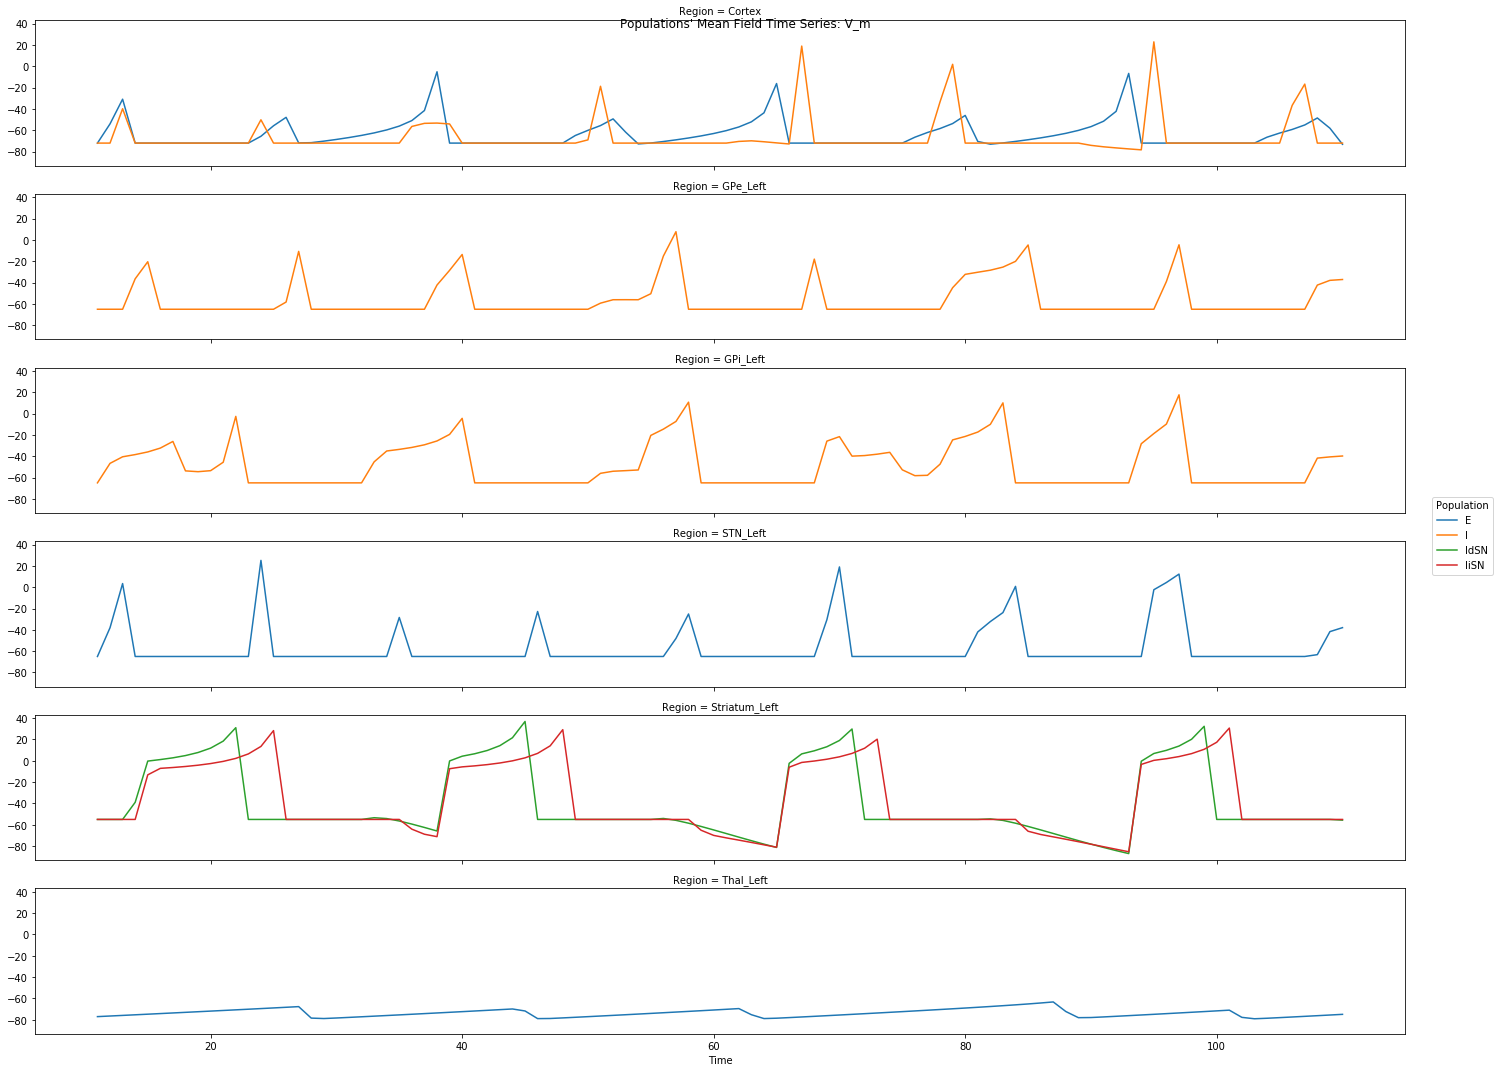

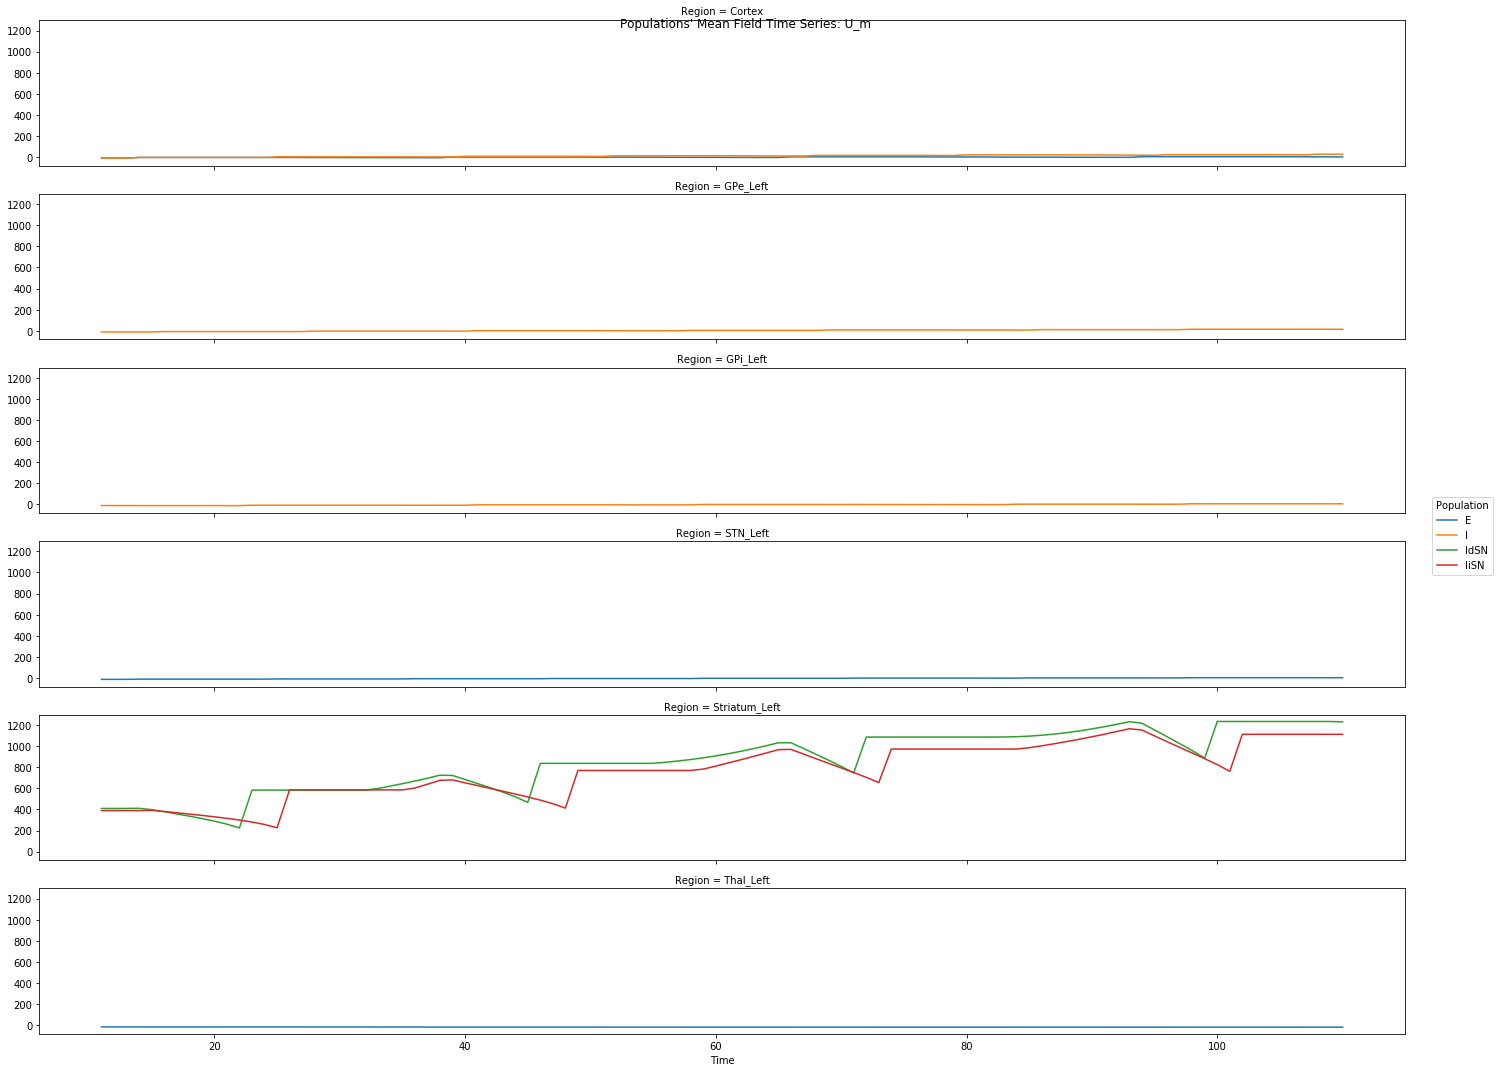

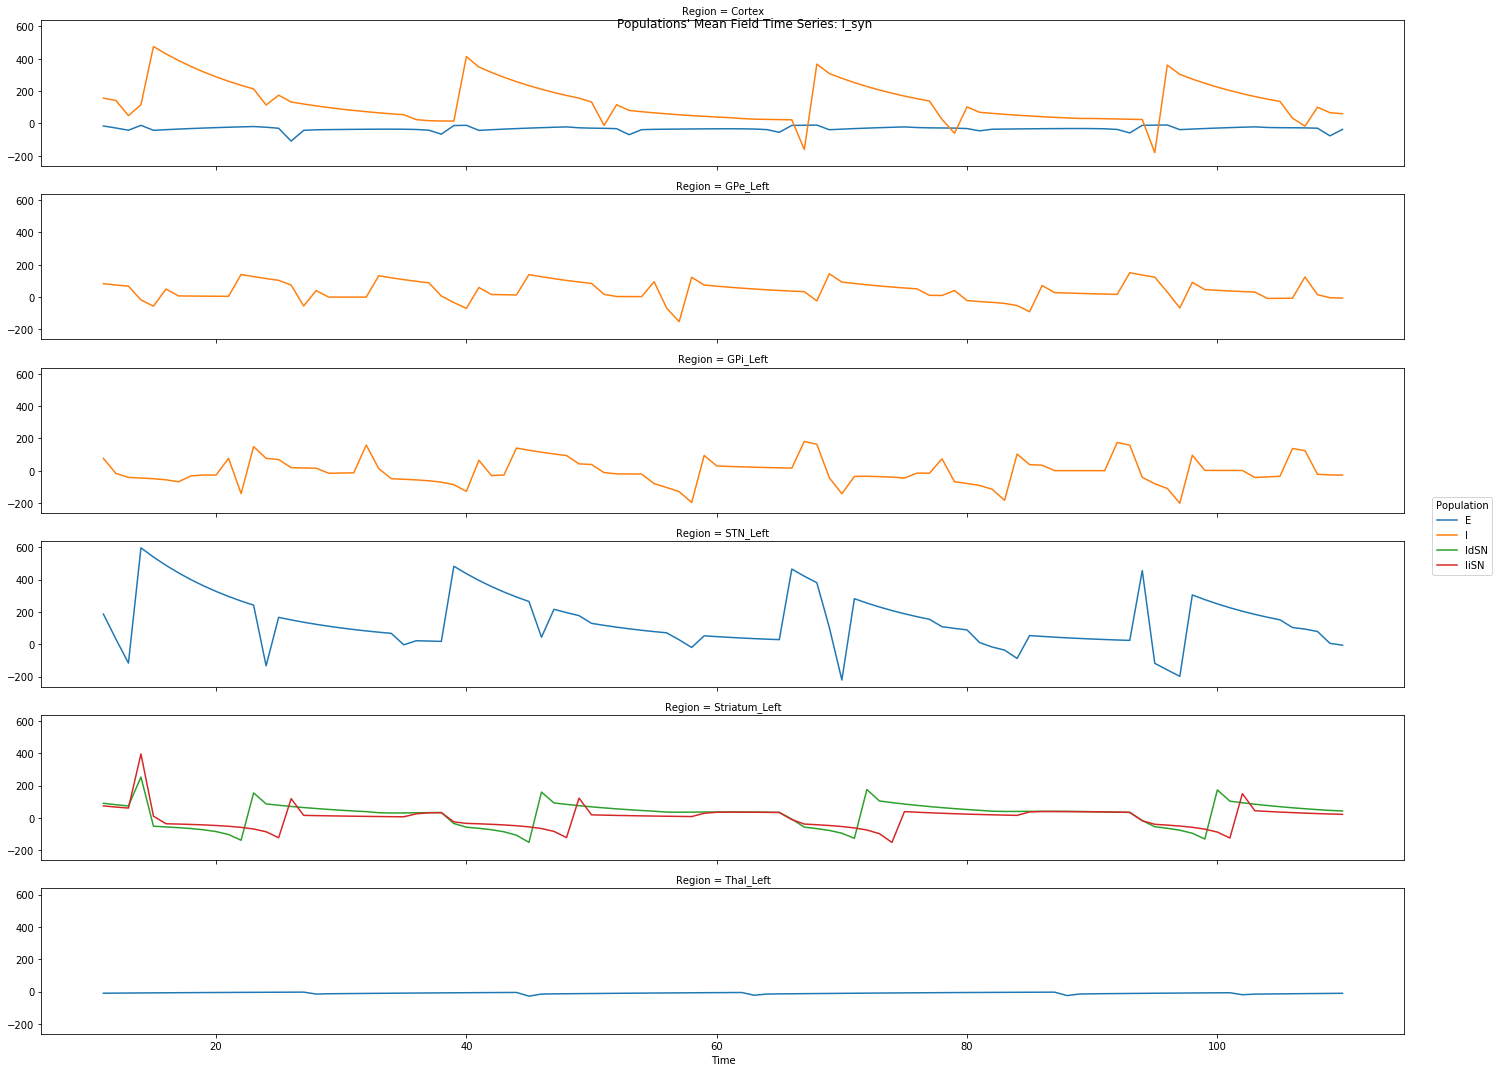

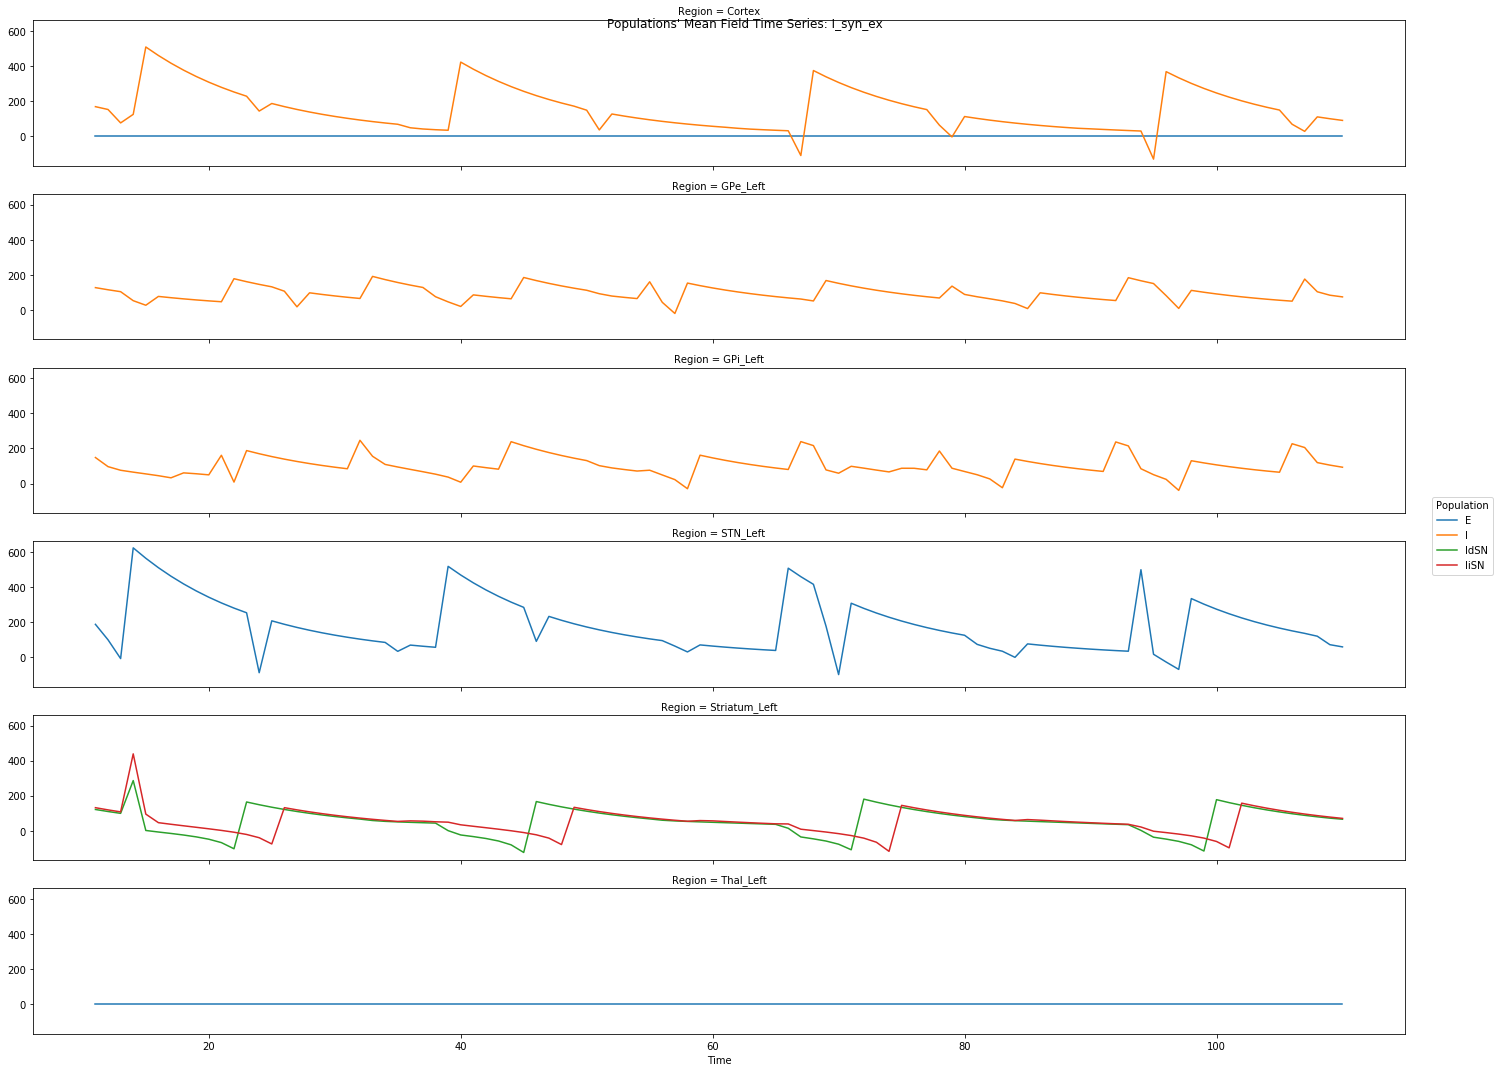

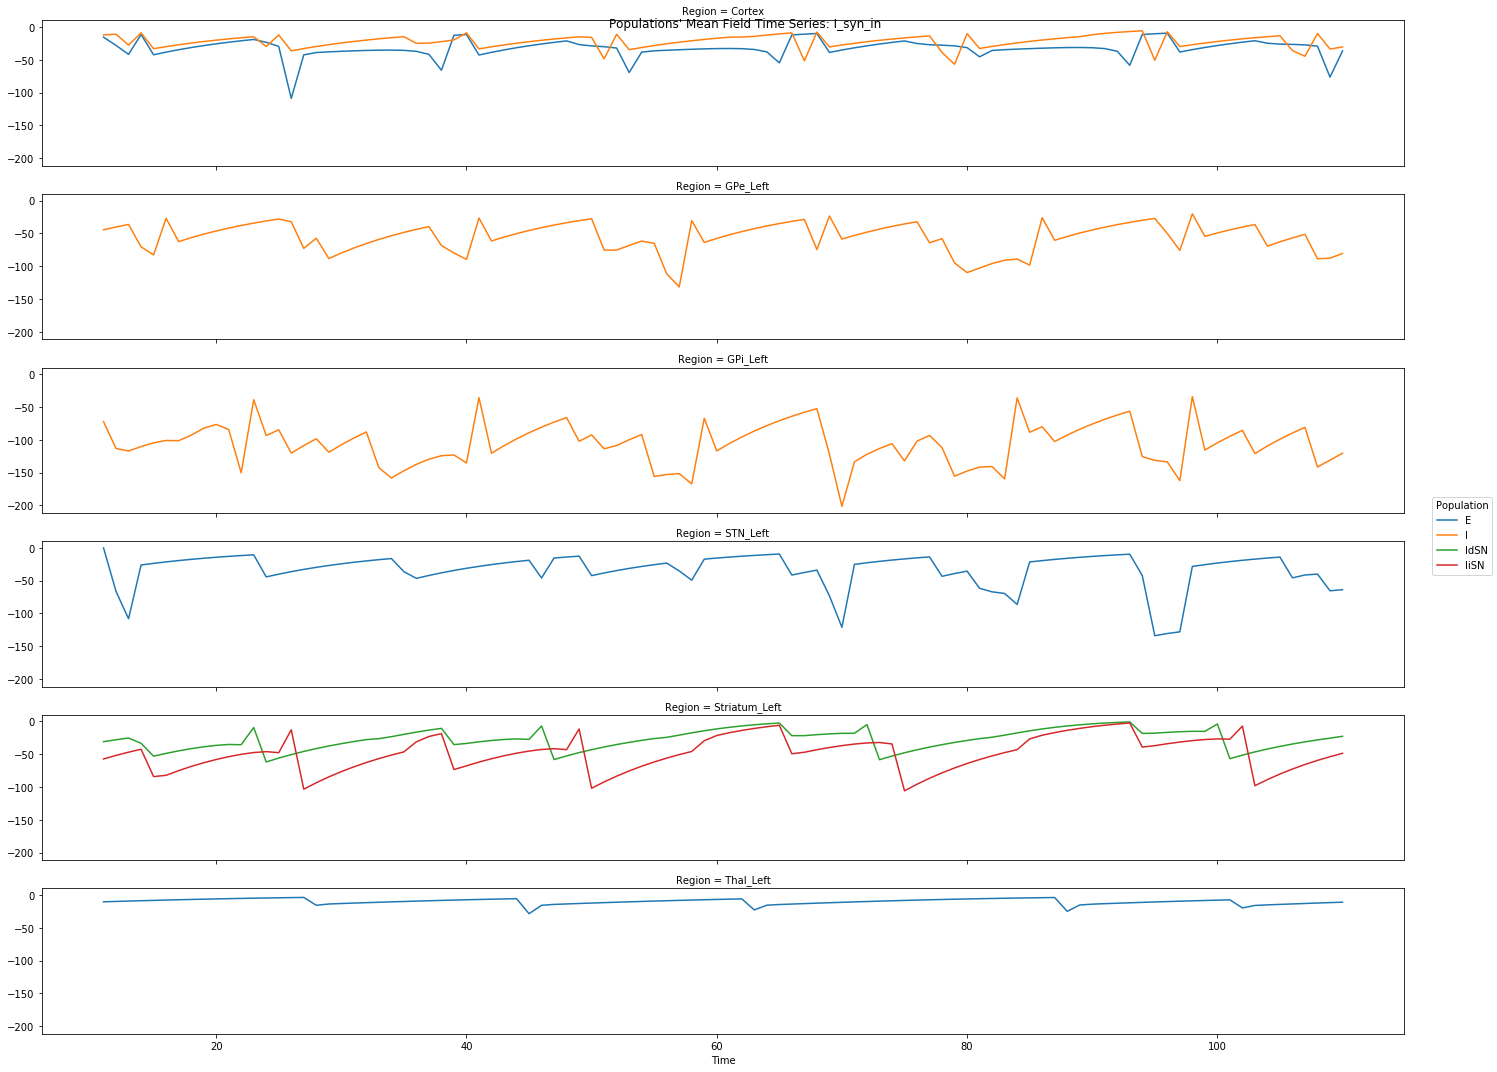

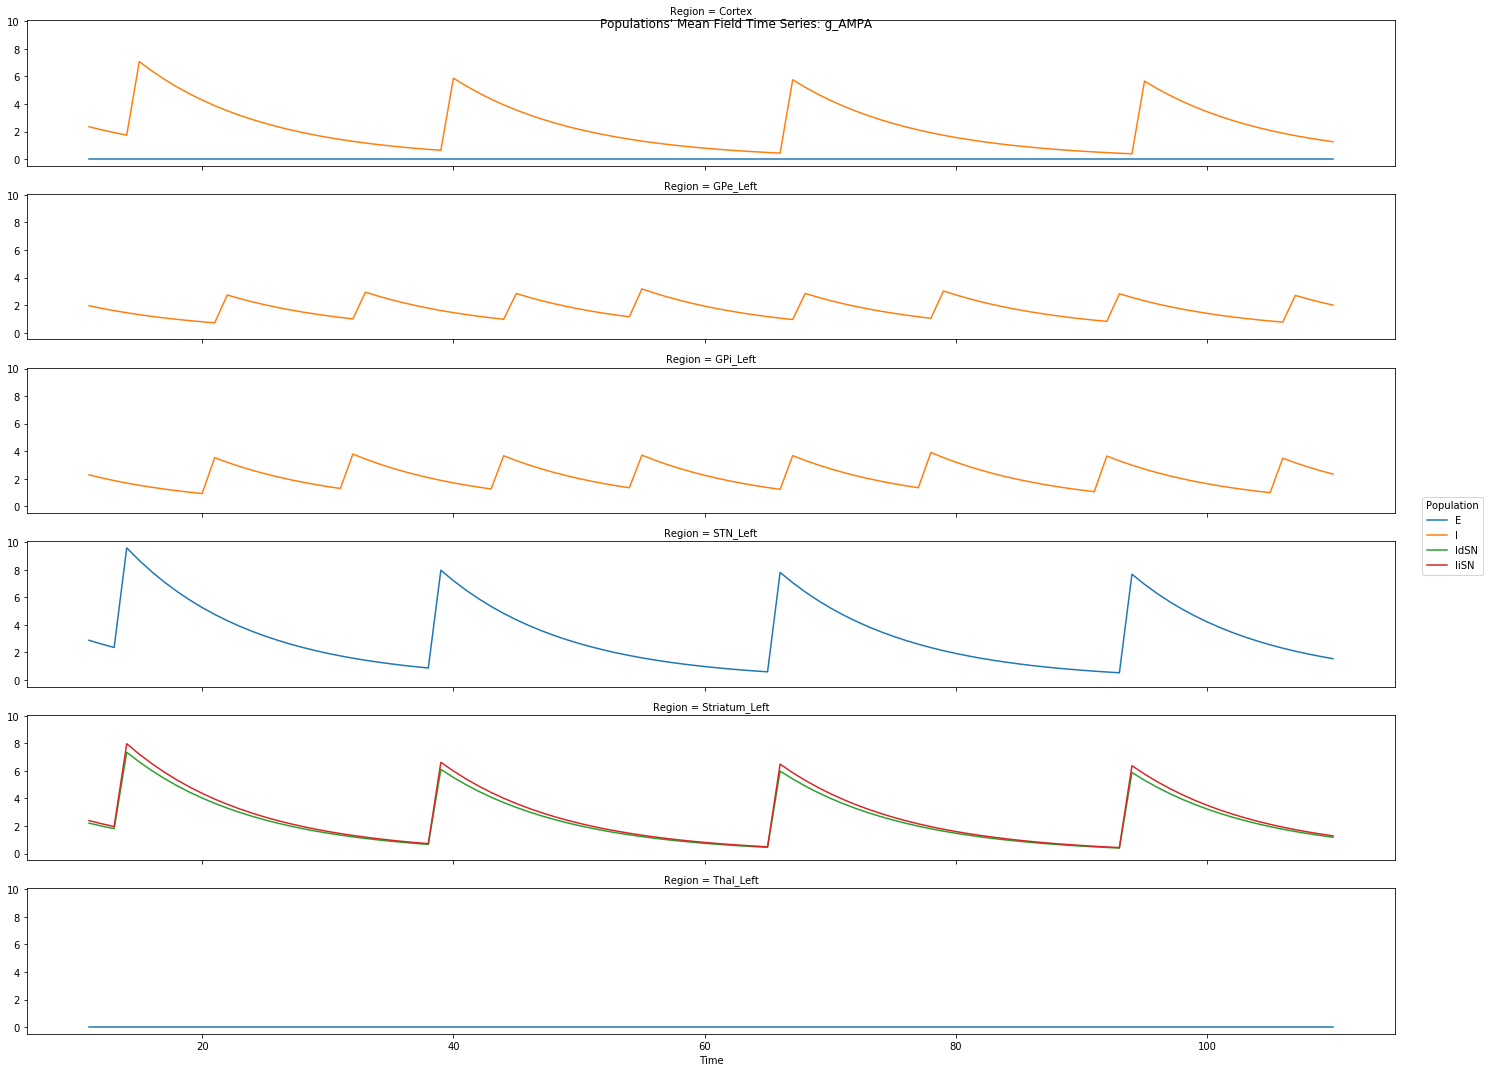

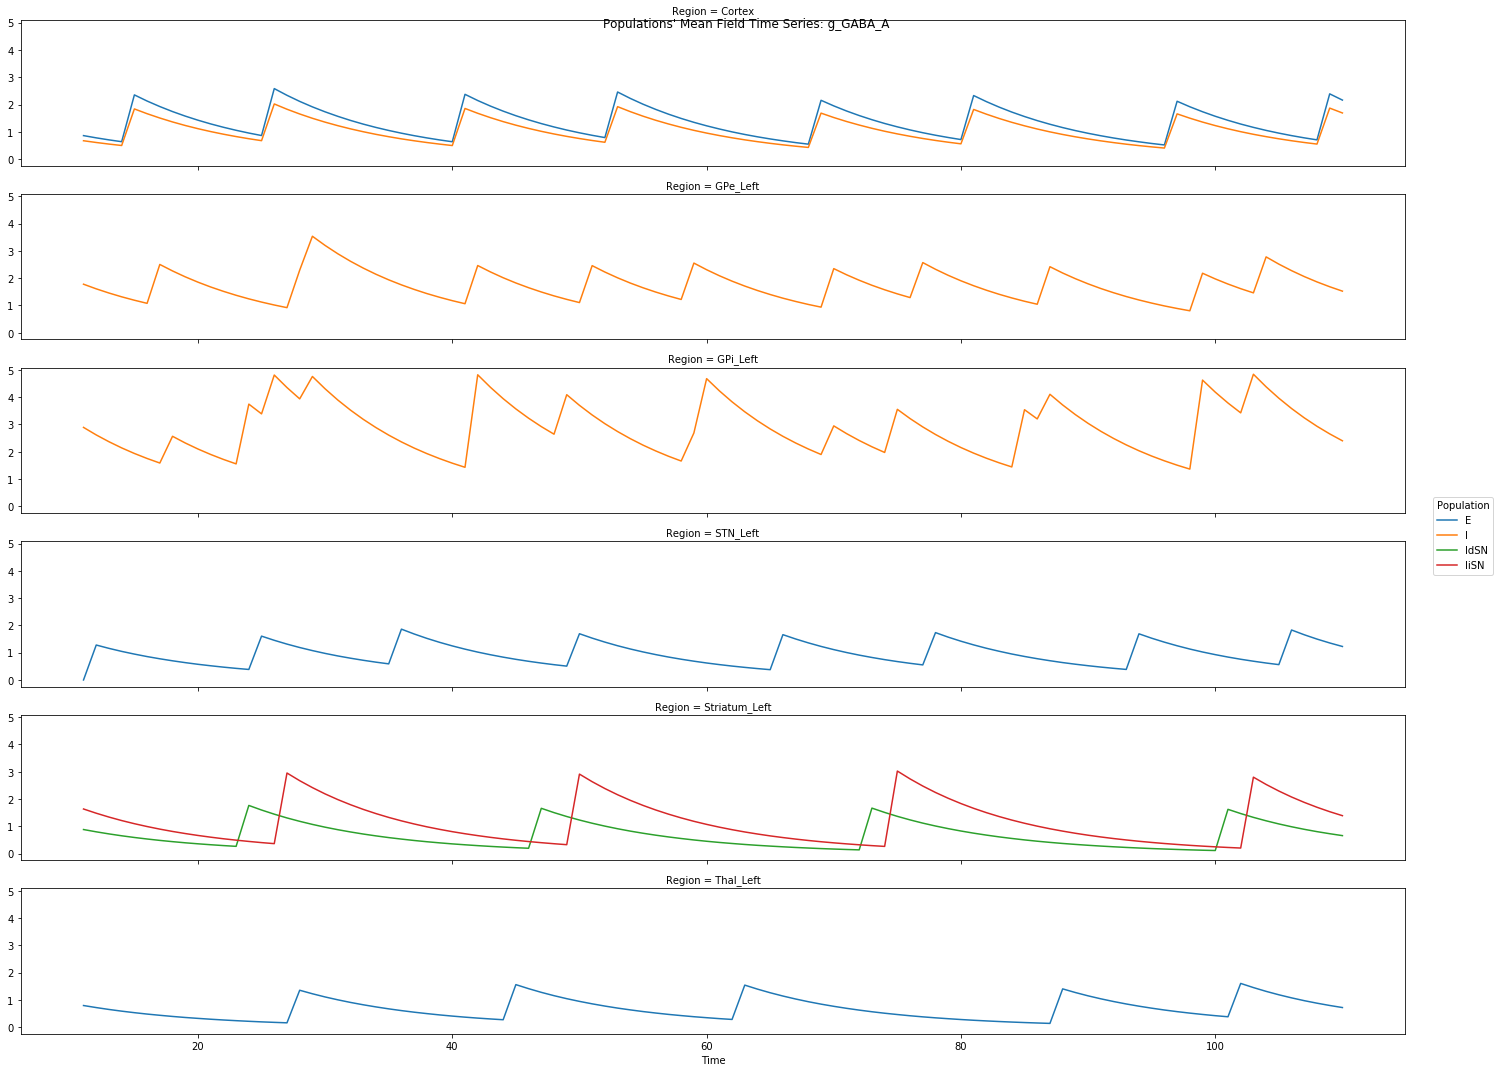

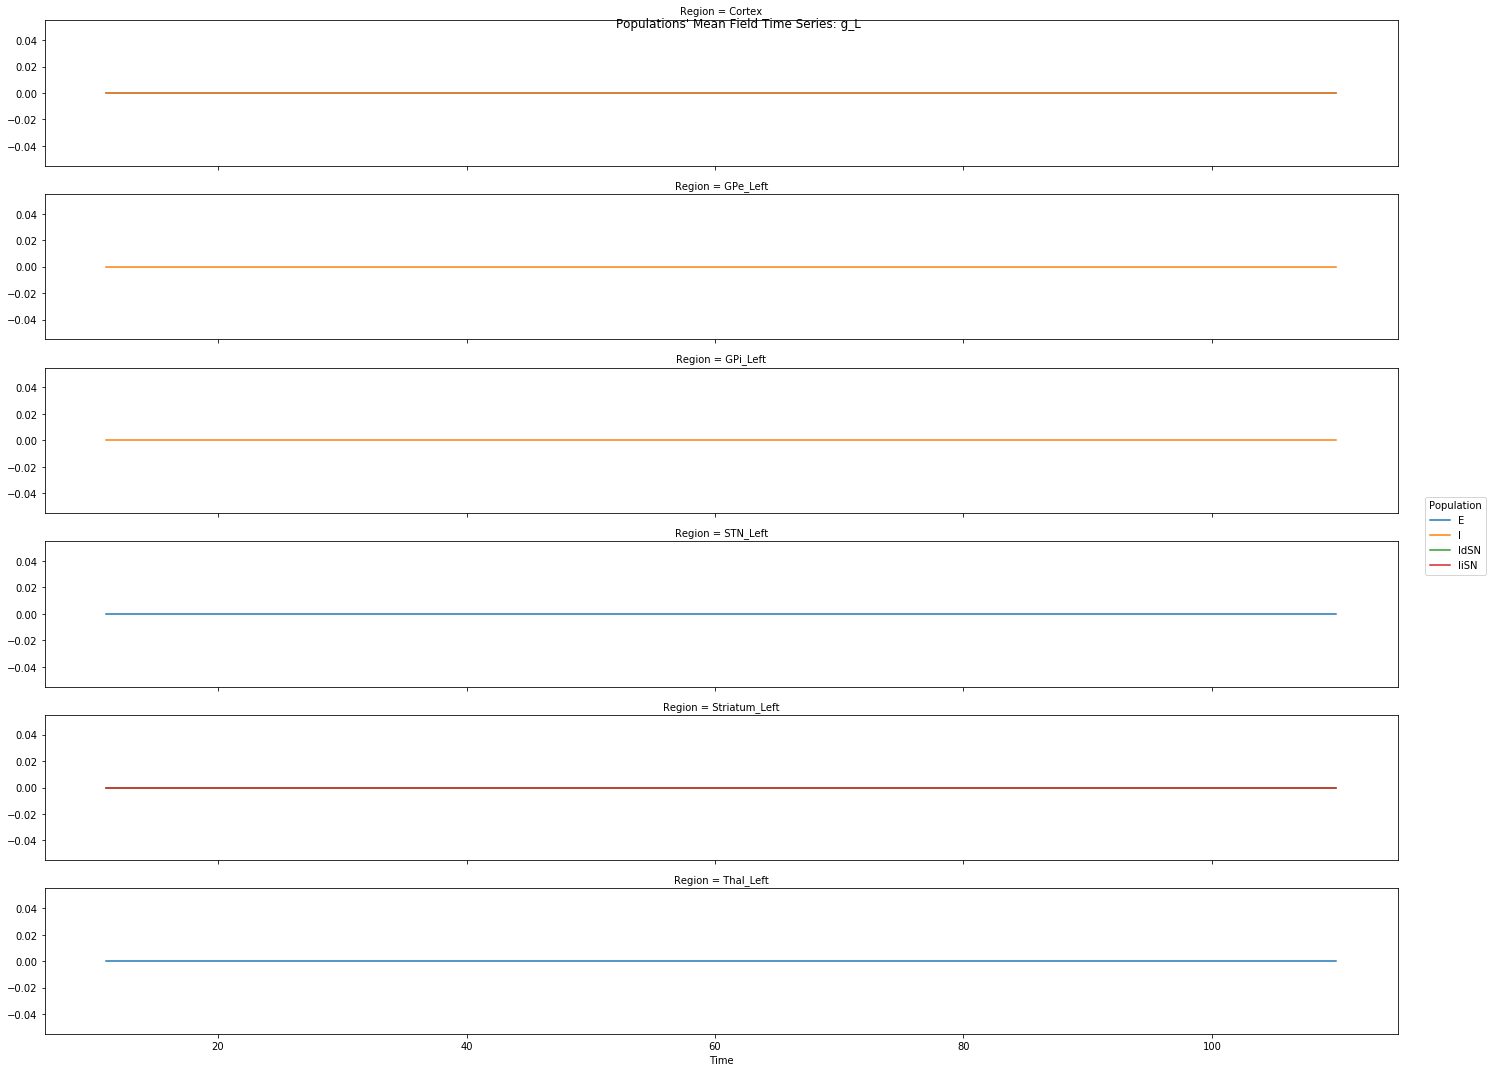

In [20]:
# Continuous time variables' data of spiking neurons
if plot_per_neuron:
    spikeNet_analyzer.return_data = True
else:
    spikeNet_analyzer.return_data = False
spikeNet_ts = \
    spikeNet_analyzer. \
         compute_spikeNet_mean_field_time_series(populations_devices=None, regions=None, variables=None,
                                                 computations_kwargs={}, data_kwargs={}, return_devices=False)
if spikeNet_ts:
    if plot_per_neuron:
        mean_field_ts = spikeNet_ts["mean_field_time_series"]  # mean field
        spikeNet_ts = spikeNet_ts["data_by_neuron"]  # per neuron data
    else:
        mean_field_ts = spikeNet_ts
    if mean_field_ts and mean_field_ts.size > 0:
        mean_field_ts.plot_timeseries(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS)
        if mean_field_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
            mean_field_ts.plot_raster(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS,
                                      linestyle="--", alpha=0.5, linewidth=0.5)
else:
    mean_field_ts = None

In [21]:
# Write results to file:
if mean_field_ts and writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                                       mean_field_ts._data,
                                       connectivity=mean_field_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, mean_field_ts.title) + ".h5", 
                           recursive=False)

### Compute per neuron spikes' rates times series and plot them

<Figure size 432x288 with 0 Axes>

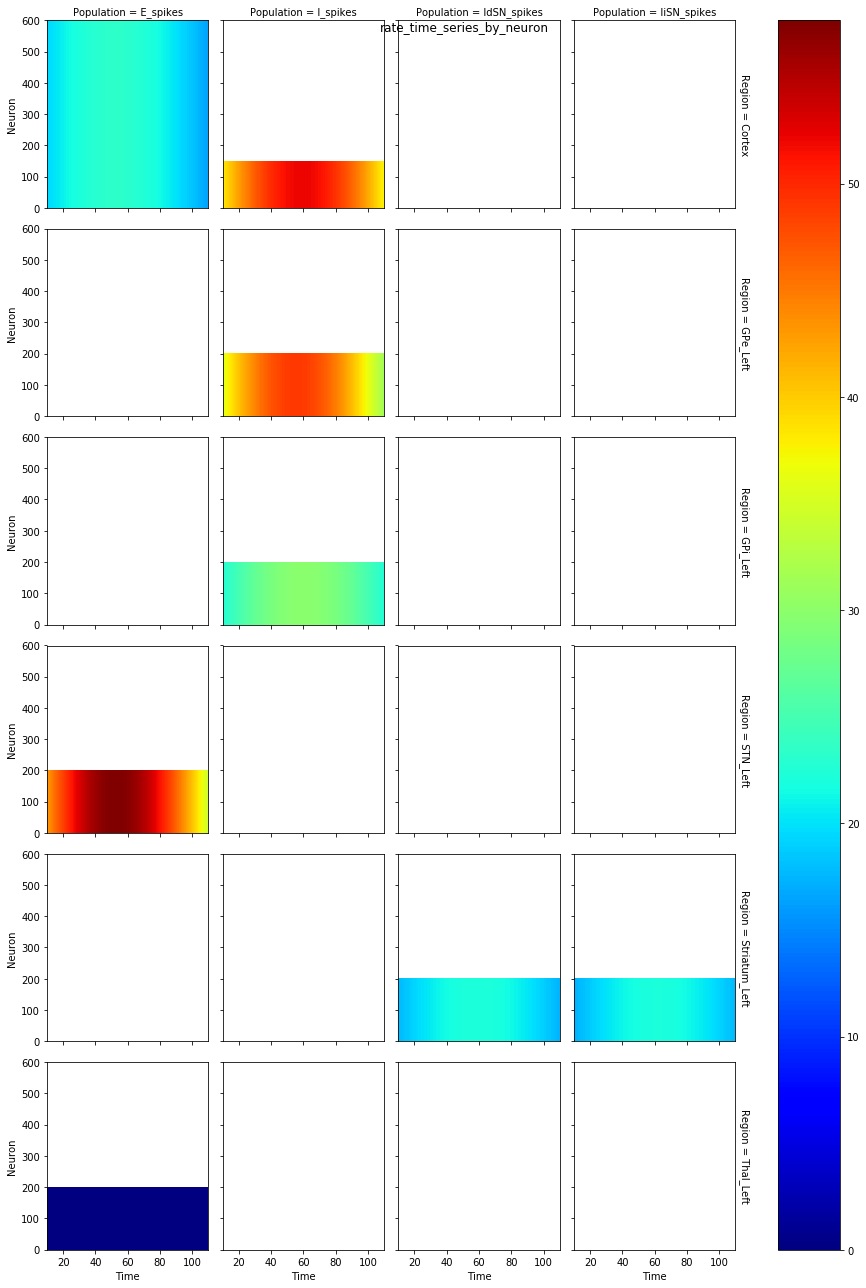

In [22]:
if spikes_res and plot_per_neuron:
    from tvb.simulator.plot.base_plotter import pyplot
    spikeNet_analyzer.return_data = False
    rates_ts_per_neuron = \
        spikeNet_analyzer. \
            compute_spikeNet_rates_time_series(populations_devices=None, regions=None,
                                               computations_kwargs={}, data_kwargs={},
                                               return_spikes_trains=False, return_devices=False);
    if rates_ts_per_neuron is not None and rates_ts_per_neuron.size:
        # Regions in rows
        row = rates_ts_per_neuron.dims[2] if rates_ts_per_neuron.shape[2] > 1 else None
        if row is None:
            # Populations in rows
            row = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
            col = None
        else:
            # Populations in columns
            col = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
        pyplot.figure()
        rates_ts_per_neuron.plot(y=rates_ts_per_neuron.dims[3], row=row, col=col, cmap="jet")
        plotter.base._save_figure(figure_name="Spike rates per neuron")
        # del rates_ts_per_neuron # to free memory

### Plot per neuron SpikingNetwork time series

<Figure size 432x288 with 0 Axes>

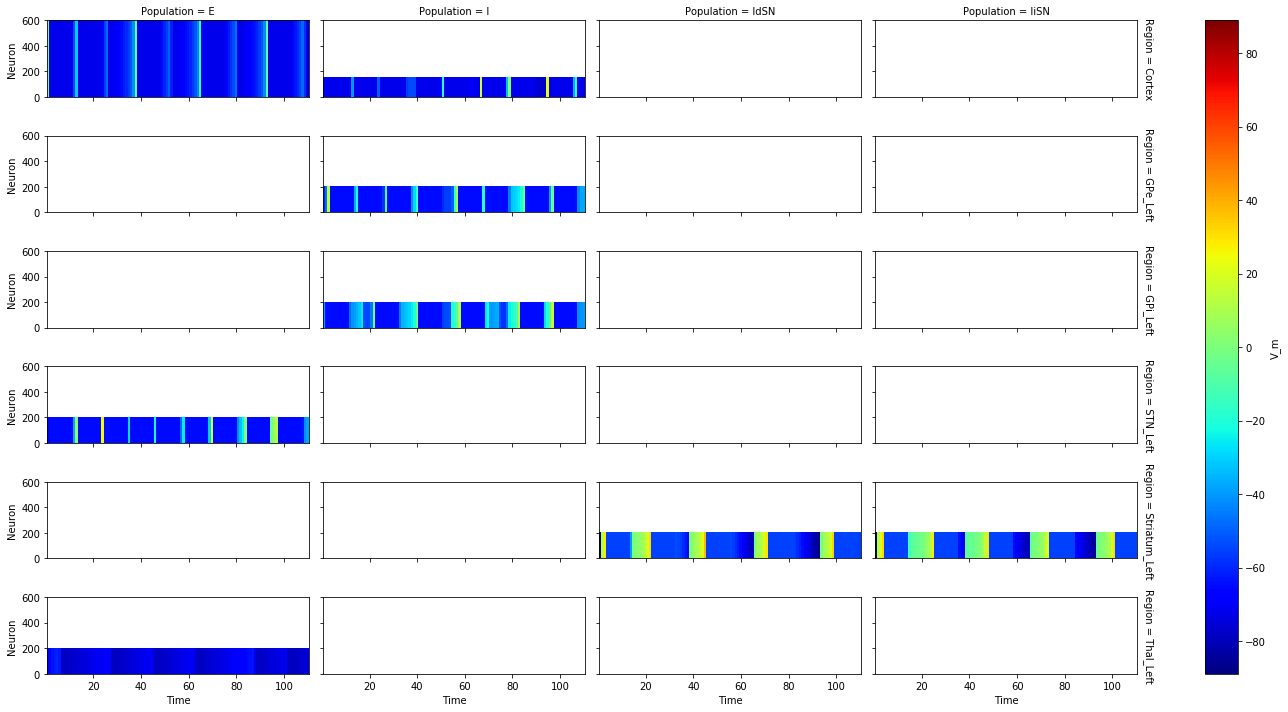

<Figure size 432x288 with 0 Axes>

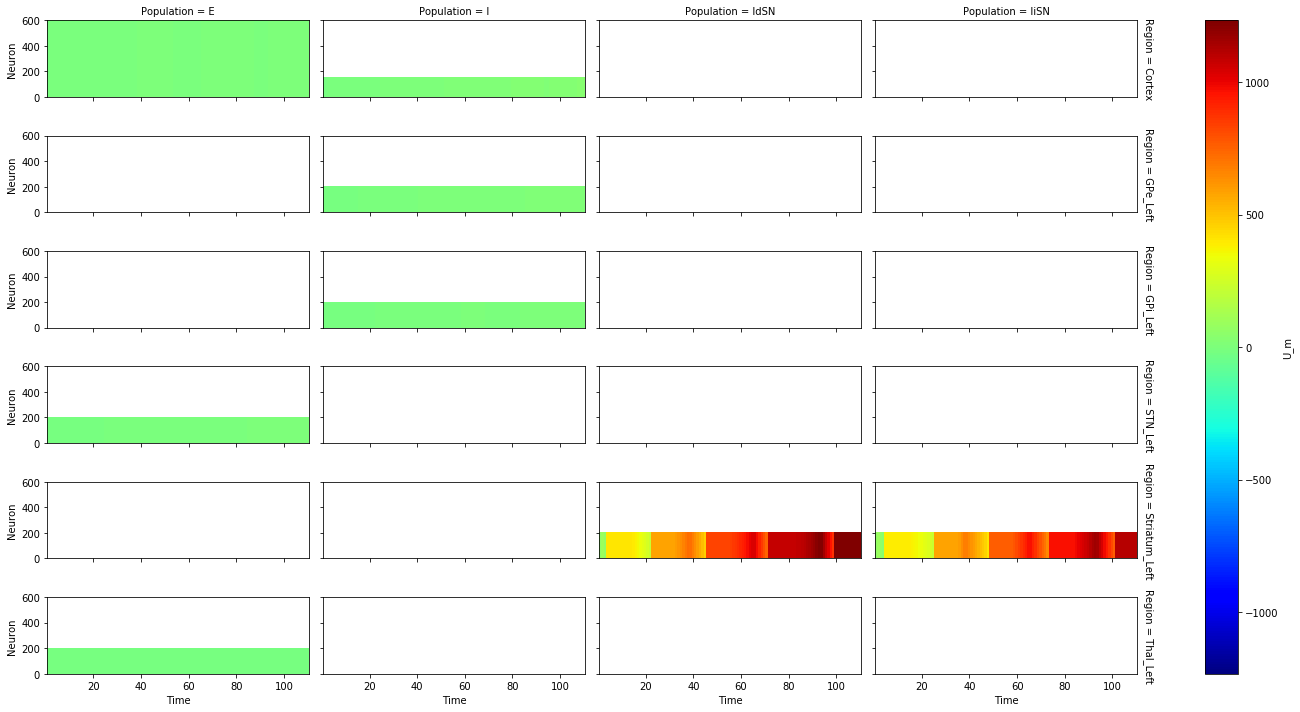

<Figure size 432x288 with 0 Axes>

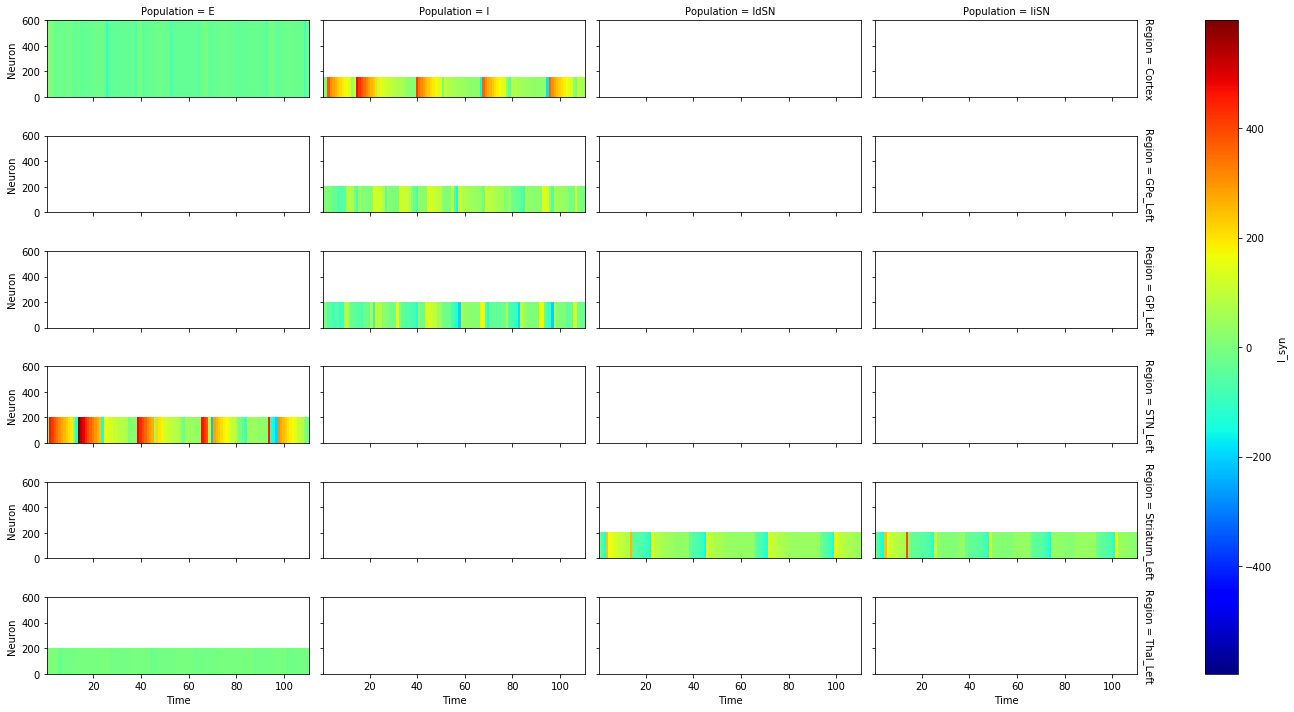

<Figure size 432x288 with 0 Axes>

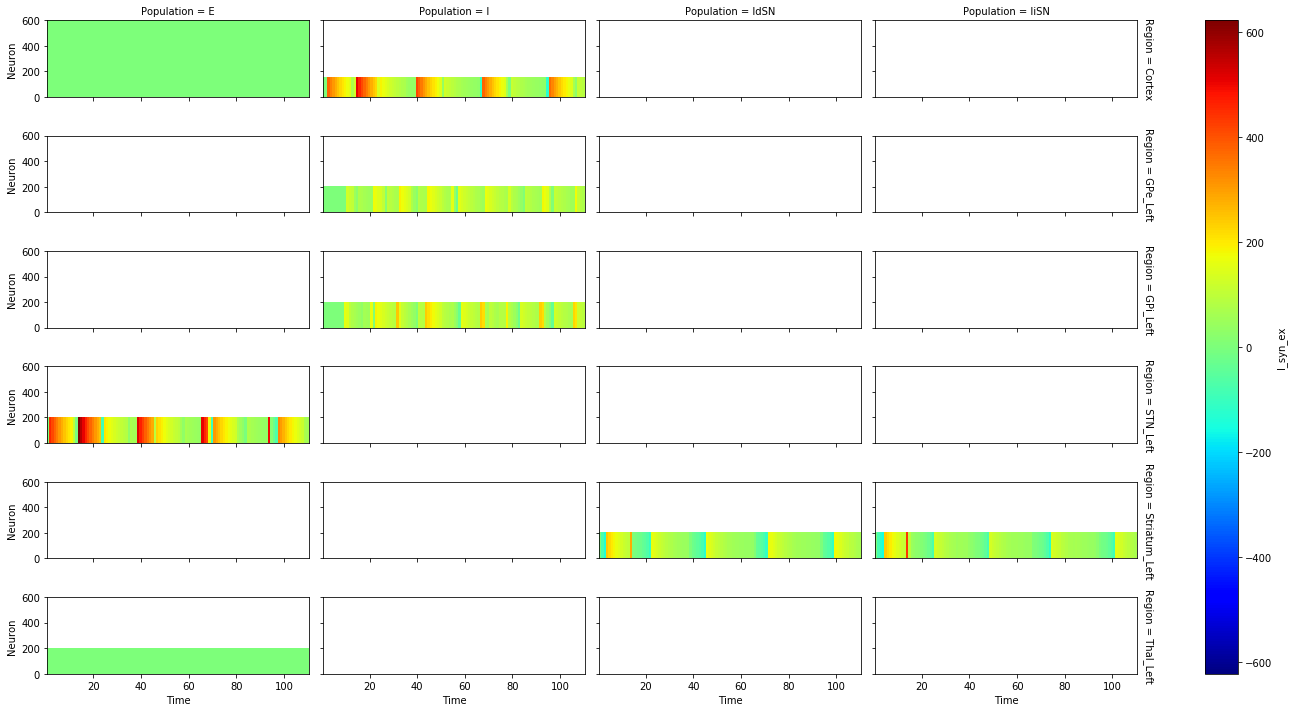

<Figure size 432x288 with 0 Axes>

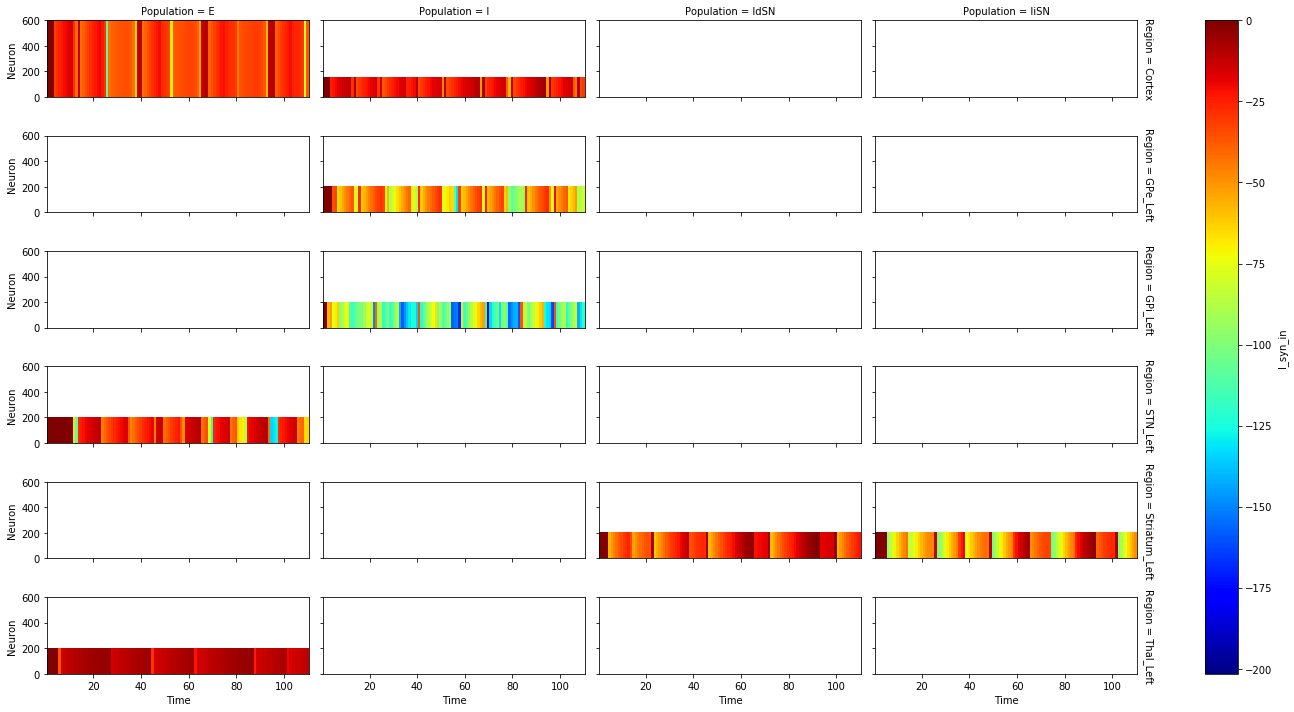

<Figure size 432x288 with 0 Axes>

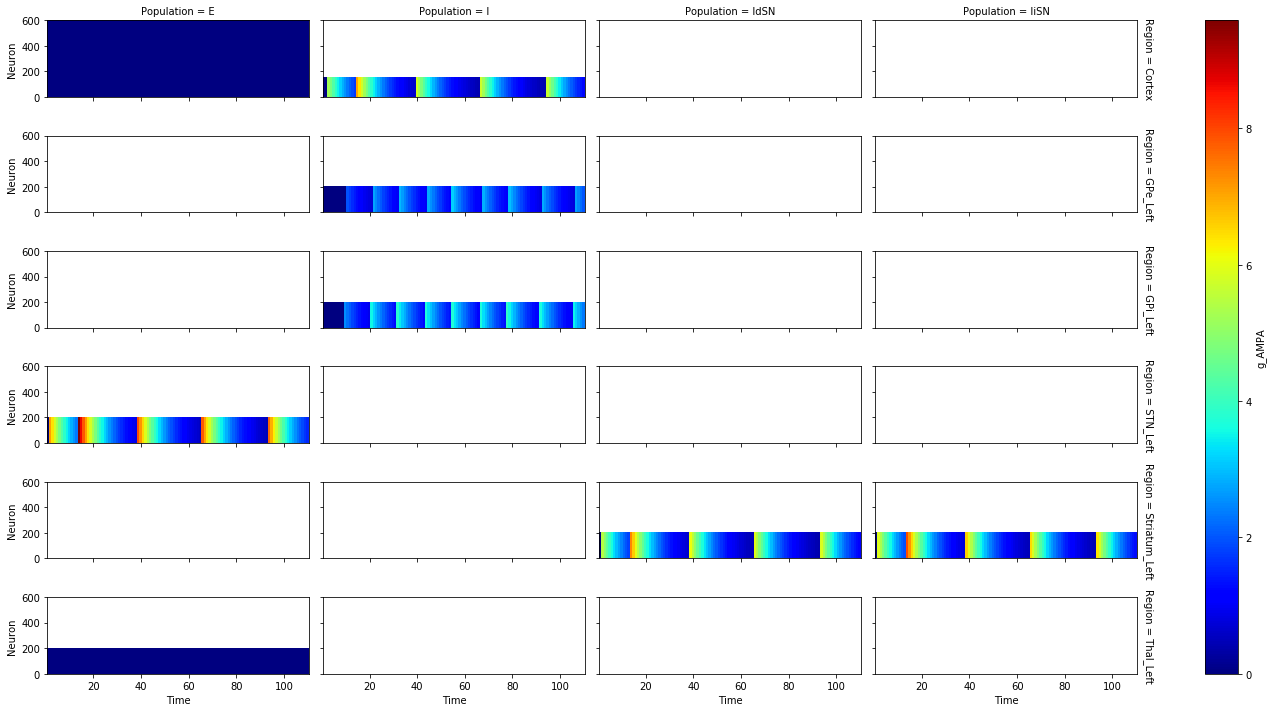

<Figure size 432x288 with 0 Axes>

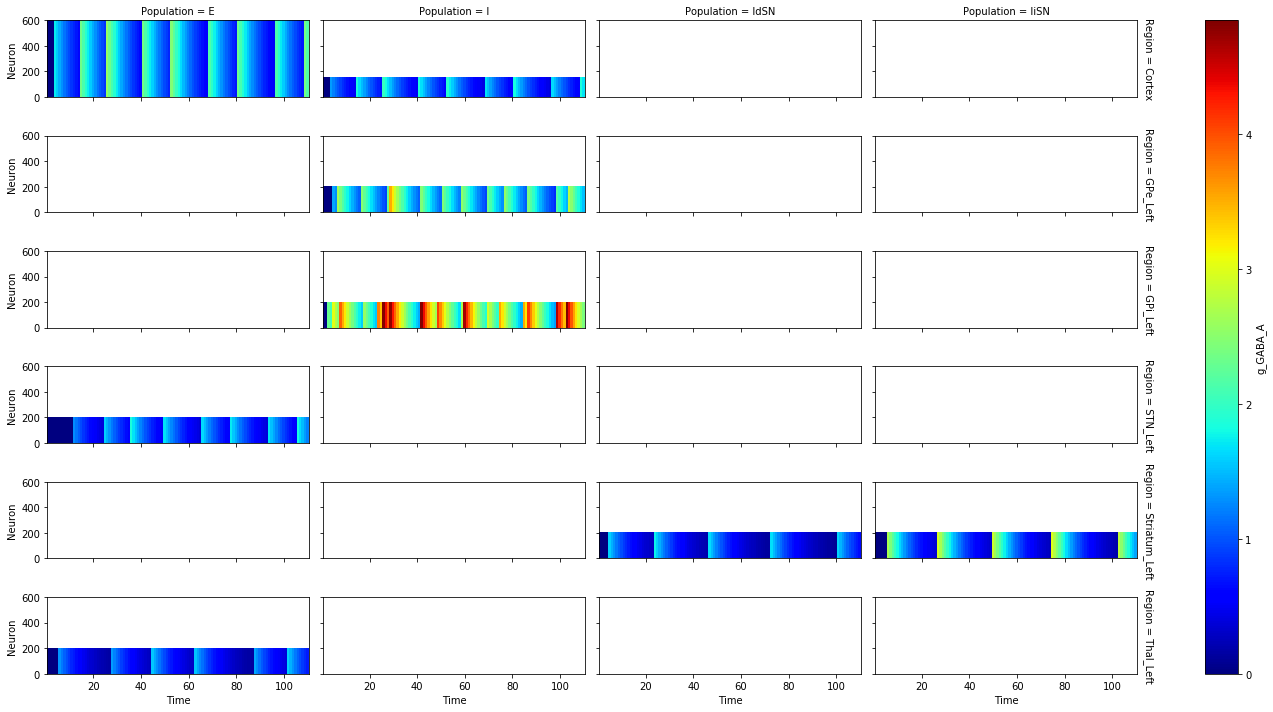

<Figure size 432x288 with 0 Axes>

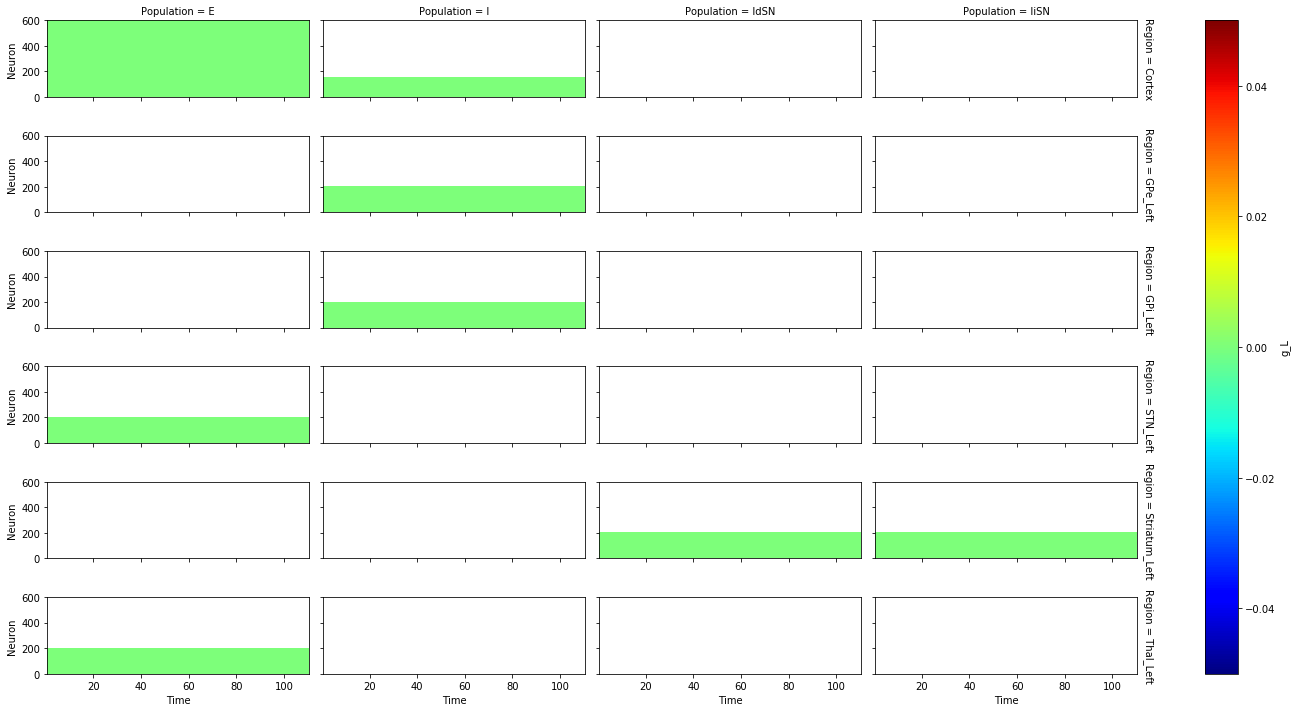

In [23]:
# Regions in rows
if plot_per_neuron and spikeNet_ts.size:
    row = spikeNet_ts.dims[2] if spikeNet_ts.shape[2] > 1 else None
    if row is None:
        # Populations in rows
        row = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
        col = None
    else:
        # Populations in cols
         col = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
    for var in spikeNet_ts.coords[spikeNet_ts.dims[1]]:
        this_var_ts = spikeNet_ts.loc[:, var, :, :, :]
        this_var_ts.name = var.item()
        pyplot.figure()
        this_var_ts.plot(y=spikeNet_ts.dims[4], row=row, col=col, cmap="jet", figsize=FIGSIZE)
        plotter.base._save_figure(
            figure_name="Spiking Network variables' time series per neuron: %s" % this_var_ts.name)
    del spikeNet_ts # to free memory

# References

1 Sanz Leon P, Knock SA, Woodman MM, Domide L, <br>
  Mersmann J, McIntosh AR, Jirsa VK (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics 7:10. doi: 10.3389/fninf.2013.00010 <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK (2013).  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>

4 Baladron, J., Nambu, A., & Hamker, F. H. (2019). <br>
  The subthalamic nucleus‐external globus pallidus loop biases <br>
  exploratory decisions towards known alternatives: A neuro‐computational study. <br>
  European Journal of Neuroscience, 49:754–767. https://doi.org/10.1111/ejn.13666 <br>
  
5 Maith O, Villagrasa Escudero F, Ülo Dinkelbach H, Baladron J, <br>
  Horn, A, Irmen F, Kühn AA, Hamker FH (2020).<br>
  A computational model‐based analysis of basal ganglia pathway changes <br>
  in Parkinson’s disease inferred from resting‐state fMRI <br>
  European Journal of Neuroscience, 00:1–18. https://doi.org/10.1111/ejn.14868
  